# Iot Challenge

## Data Dictionnary

### Features for trainning

- mssid: Message ID, identify the message
- bsid: Base ID od the station that detects the message ID
- did:  Device ID, if the  device that sent the signal
- nseq: sequence number 
- rssi: intensity of the signal of the message 
- time_ux: timestamp of signal 
- bs_lat : latitude of the base that receive the signal
- bs_lng : longitude of the base that receive the signal

###  Features to predict

- lat: latitude position to predict 
- long : longitude position to predict

# Set up 

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from ipyleaflet import Map, basemaps, basemap_to_tiles,Marker,MarkerCluster
from vincenty import vincenty

# Load Dataset

In [3]:
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [4]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [5]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


# Data Analysis

### Are there null or Nan values in the dataset?

In [6]:
df_mess_train.isnull().sum()

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

In [7]:
df_mess_train.isna().sum()

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

In [8]:
df_mess_test.isnull().sum()

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

In [9]:
df_mess_test.isna().sum()

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

### What are the data types?

In [10]:
df_mess_train.dtypes

messid      object
bsid         int64
did        float64
nseq       float64
rssi       float64
time_ux    float64
bs_lat     float64
bs_lng     float64
dtype: object

In [11]:
df_mess_test.dtypes

messid      object
bsid         int64
did        float64
nseq       float64
rssi       float64
time_ux    float64
bs_lat     float64
bs_lng     float64
dtype: object

In [12]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


 We should convert bsid, and did to object types

In [13]:
for col in ['bsid','did']:
    df_mess_test[col] = df_mess_test[col].astype(str)
    df_mess_train[col] = df_mess_train[col].astype(str)

In [14]:
df_mess_test.dtypes

messid      object
bsid        object
did         object
nseq       float64
rssi       float64
time_ux    float64
bs_lat     float64
bs_lng     float64
dtype: object

### Where are the base stations?

In [15]:
def Give_Marker_Cluster(df) :
    markers = []
    for i in df.index :
        x = df.loc[i].bs_lat
        y = df.loc[i].bs_lng
        name = str(df.loc[i].bsid)
        markers.append(Marker(location = (x,y),draggable = False, title = name))

    return MarkerCluster(markers=(markers))

In [16]:
df_Coord = df_mess_train.drop_duplicates(subset ="bsid", 
                                       keep = 'first')[['bsid','bs_lat','bs_lng']]

m = Map(center=(46, -1), zoom=2,
        basemap = basemaps.Stamen.Watercolor)

markerC = Give_Marker_Cluster(df_Coord)

m.add_layer(markerC)
display(m)

Map(center=[46, -1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

We can clearly notice that there are 2 main locations of bases:
- The first one is in the USA
- The second one in Canada

It is probable that the bases in main location interact only with each other. So we could split the analyses into 2 models the canadian and the american .

### Are there anormal locations?

In [17]:
df_train  = df_mess_train.copy()

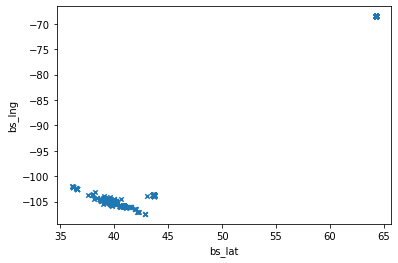

In [18]:
df_train.plot( 'bs_lat', 'bs_lng', marker = 'x', kind = 'scatter')
plt.show()

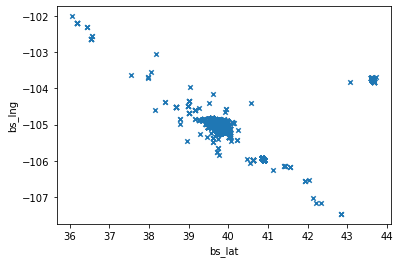

In [19]:
df_train.loc[df_train['bs_lat']<50].plot( 'bs_lat', 'bs_lng', marker = 'x', kind = 'scatter')
plt.show()

There seems to be 2 main groups of points. We could label them to canadian or american.

### Is the canadian group important?

In [20]:
len(df_train.loc[df_train['bs_lat']>60])

4389

In [21]:
df_train.loc[df_train['bs_lat']>60]['bs_lat'].nunique()

1

In [22]:
df_train.loc[df_train['bs_lat']>60]['bs_lng'].nunique()

1

In [23]:
df_train.loc[df_train['bs_lat']>60]['bsid'].nunique()

27

In [24]:
df_train.loc[df_train['bs_lat']>60]['messid'].nunique()

1849

It seems like the 27 bases in Canada are in the same exact position.
But there are related to more than 4389 signals, and 1849 messages. 

### Are there other bases in the same location?

In [25]:
nb_bases_per_location = df_train.groupby(by = ['bs_lat', 'bs_lng']).nunique()[['bsid']].sort_values("bsid")
nb_bases_per_location.columns = ['nb_bsid']
nb_bases_per_location = nb_bases_per_location.reset_index()
nb_bases_per_location.loc[nb_bases_per_location['nb_bsid']>1]

,bs_lat,bs_lng,nb_bsid
216,39.680252,-104.925515,2
217,39.706436,-105.099323,2
218,39.730087,-104.919391,2
219,39.759461,-105.074287,2
220,64.300000,-68.500000,27


### What is the average distance between a message and bases?

In [26]:
df_train = df_mess_train.copy()
df_train['lat'] = pos_train['lat']
df_train['lng'] = pos_train['lng']

In [27]:
def distance_message_base (row) : 
    distance = vincenty((row["lat"], row["lng"]), (row["bs_lat"], row["bs_lng"]))
    return distance

In [28]:
df_train['distance_message_base'] = df_train.apply(distance_message_base, axis = 1)

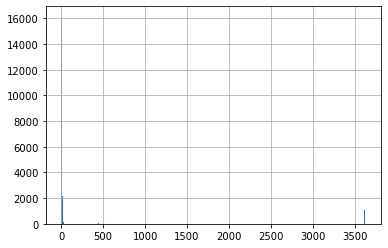

In [29]:
df_train['distance_message_base'].hist(bins = 1000)

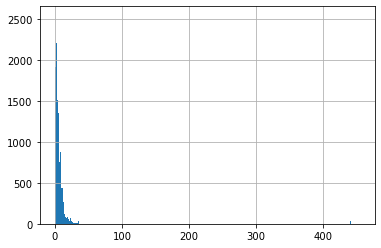

In [30]:
df_train.loc[df_train['distance_message_base']<500]['distance_message_base'].hist(bins = 1000)
plt.show()

In [31]:
df_train.describe()[['distance_message_base']]

,distance_message_base
count,39250.000000
mean,410.752011
std,1135.801553
min,0.026570
25%,2.253913
50%,4.686167
75%,9.829309
max,3628.655909


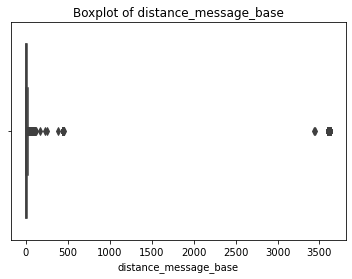

In [32]:
sns.boxplot(data = df_train, x = 'distance_message_base');
plt.title("Boxplot of distance_message_base")
plt.show()

We can notice that some points are outside/ far from the usual distributions, which is less than 500 . 

### Are there any relationship between the data points in the dataset?

In [33]:
df_train

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,distance_message_base
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,1.270478
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,7.849924
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,5.131578
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,11.681759
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,1.356862
...,...,...,...,...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,3410,476257.0,1.0,-128.000000,1.481140e+12,39.777690,-105.002424,39.773264,-105.014052,1.110804
39246,5848672e12f14360d7942374,8352,476257.0,0.0,-121.000000,1.481140e+12,39.761633,-105.025753,39.773264,-105.014052,1.634839
39247,5848672e12f14360d7942374,8397,476257.0,2.0,-126.000000,1.481140e+12,39.759396,-105.001415,39.773264,-105.014052,1.882449
39248,58487473e541cd0e133cca72,3051,476593.0,1.0,-131.333333,1.481143e+12,39.898872,-105.153832,39.908186,-105.168297,1.612307


<Figure size 1440x1440 with 0 Axes>

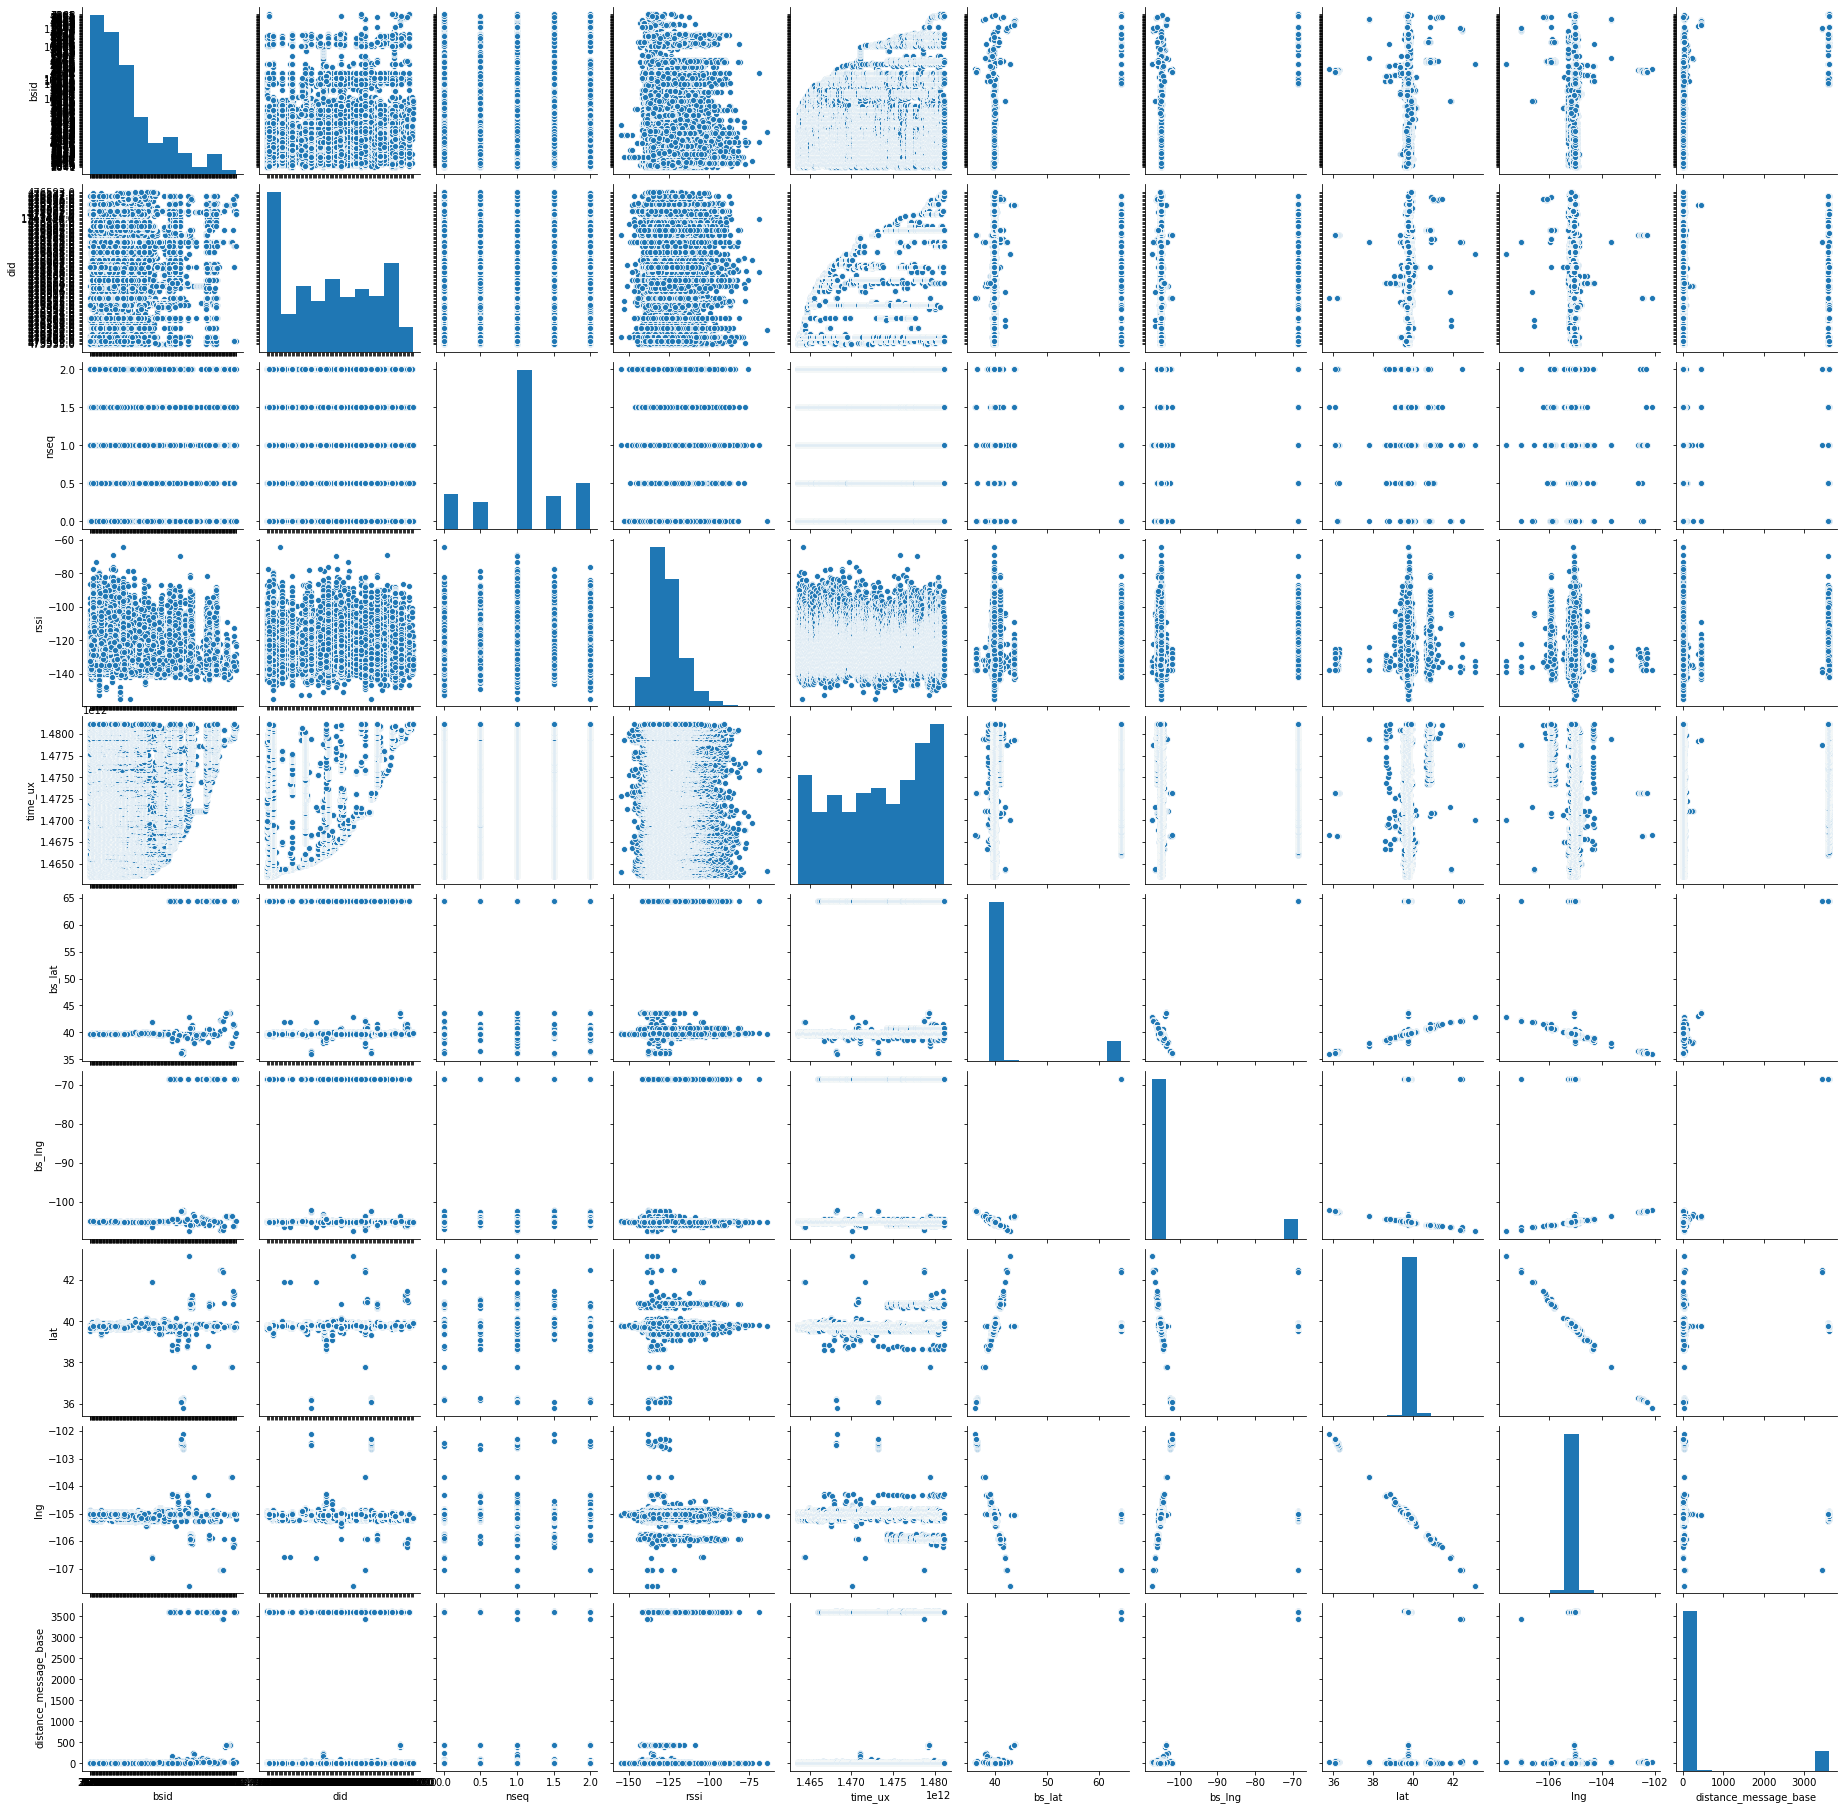

In [34]:
plt.figure(figsize = (20,20))
sns.pairplot(df_train);
plt.show()

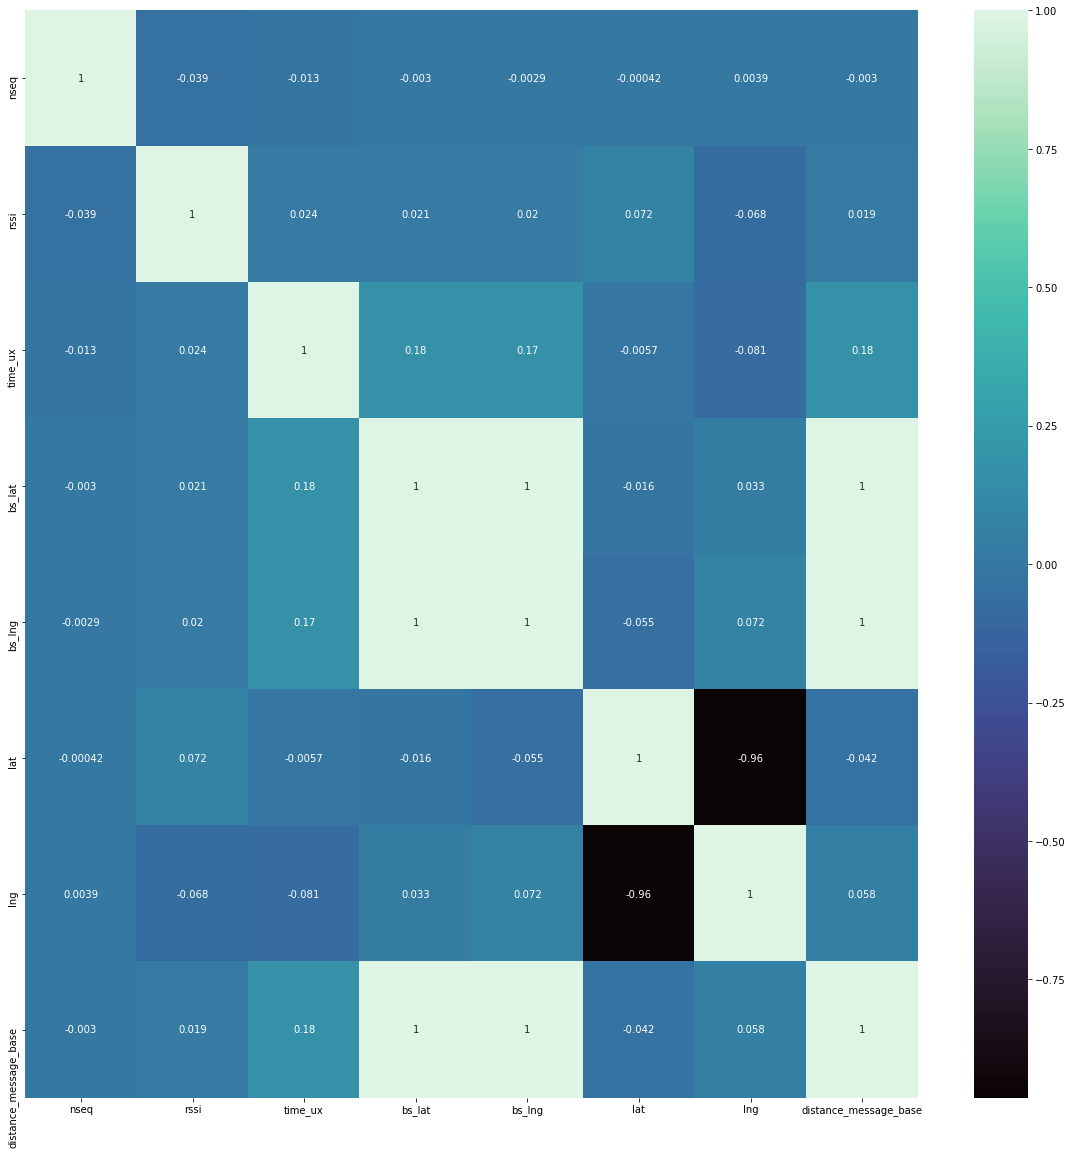

In [35]:
plt.figure(figsize=(20,20))
sns.heatmap(df_train.corr(), cmap = 'mako', annot = True)
plt.show()

- Latitude is highly correlated with longitude, and the relationship seem to be linear
- The correlation coefficients are not really high individually. 
- The most correlated appearing features with longitude and latitude are time, rssi, and bs_lng

### Is there any relation between the intensity of the signal and the distance between message and base?

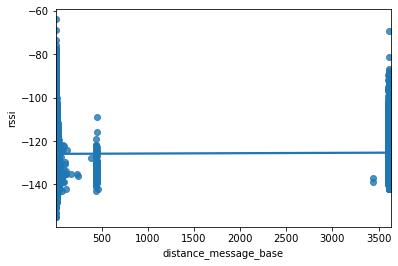

In [36]:
sns.regplot(data = df_train, x= 'distance_message_base', y = 'rssi') ;

There seem to be 2 groups, let's zoom in. 

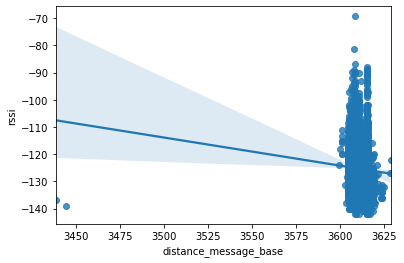

In [37]:
sns.regplot(data = df_train.loc[df_train['distance_message_base']>1500], x= 'distance_message_base', y = 'rssi') ;

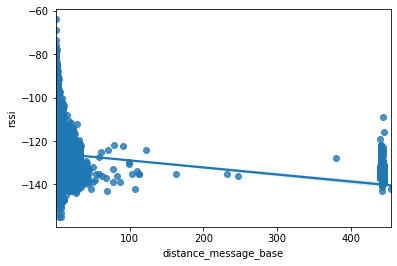

In [38]:
sns.regplot(data = df_train.loc[df_train['distance_message_base']<1500], x= 'distance_message_base', y = 'rssi') ;

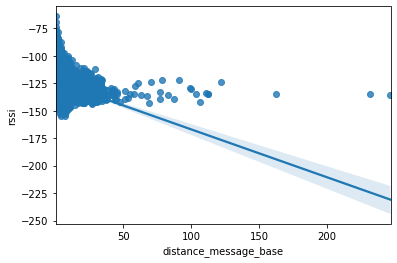

In [39]:
sns.regplot(data = df_train.loc[df_train['distance_message_base']<300], x= 'distance_message_base', y = 'rssi') ;

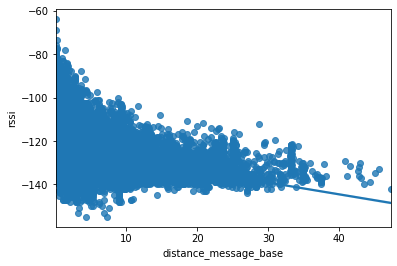

In [40]:
sns.regplot(data = df_train.loc[df_train['distance_message_base']<50], x= 'distance_message_base', y = 'rssi') ;

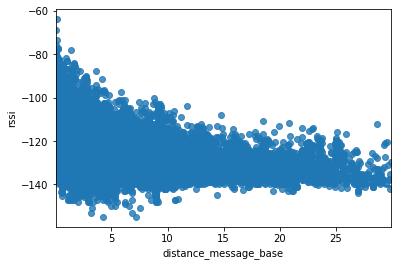

In [41]:
sns.regplot(data = df_train.loc[df_train['distance_message_base']<30], x= 'distance_message_base', y = 'rssi') ;

We could notice a non linear behavior between rssi and the distance to the base.

###  What are the GPS coordinate test the same as in the train? Are they the same?

In [42]:
df_Coord = df_mess_test.drop_duplicates(subset ="bsid", 
                                       keep = 'first')[['bsid','bs_lat','bs_lng']]

m = Map(center=(46, -1), zoom=2,
        basemap = basemaps.Stamen.Watercolor)

markerC = Give_Marker_Cluster(df_Coord)

m.add_layer(markerC)
display(m)

Map(center=[46, -1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

There are more bases in the train data than the test data.

In [43]:
bases_train = df_mess_train[['bsid', 'bs_lat', 'bs_lng']]
bases_train = bases_train.drop_duplicates()
bases_train

,bsid,bs_lat,bs_lng
0,2841,39.617794,-104.954917
1,3526,39.677251,-104.952721
2,2605,39.612745,-105.008827
3,2610,39.797969,-105.073460
4,3574,39.723151,-104.956216
...,...,...,...
33400,7972,41.396888,-106.131664
34250,1854,64.300000,-68.500000
35119,4813,39.417820,-104.968154
37074,3385,39.893410,-104.841287


In [44]:
bases_test = df_mess_test[['bsid', 'bs_lat', 'bs_lng']]
bases_test = bases_test.drop_duplicates()
bases_test

,bsid,bs_lat,bs_lng
0,3578,39.728651,-105.163032
1,2617,39.779908,-105.062479
2,3556,39.780658,-105.053676
4,4058,39.783211,-105.088747
5,7456,39.782113,-105.072701
...,...,...,...
21652,2707,64.300000,-68.500000
21720,2943,64.300000,-68.500000
23771,1092,64.300000,-68.500000
27601,1854,64.300000,-68.500000


The train data contains more bases than the test data.

In [45]:
print("Bases ID in test but not in train ")
for base in list(bases_test['bsid']): 
    if base not in list(bases_train['bsid']):
        print(base)

Bases ID in test but not in train 
3034
3828
9783
9949
9936
9941
8168
1131


There are only 8 bases out of 168 that are in test but not in train. 

In [46]:
print("Bases ID in train but not in test ")
for base in  list(bases_train['bsid']): 
    if base not in list(bases_test['bsid']):
        print(base)

Bases ID in train but not in test 
3515
4996
4088
8495
4049
1235
2836
7849
10148
1463
1229
980
3544
2775
8384
1526
7490
1148
1534
2766
2780
3546
4055
3915
7986
7857
1828
3577
4060
4790
3613
944
4024
1447
1156
1187
1226
1237
1971
2293
2611
2849
2945
3041
3549
3646
4959
7378
7628
8079
8242
8442
10999
8405
1730
7807
1581
2845
7673
1266
1120
8401
4073
1838
4123
879
2770
911
921
2855
11951
9784
2765
7508
3848
2803
2808
3630
2800
3933
3501
4013
1443
3572
8226
8390
7655
1852
7972
4813
3385


### Are the number of messages per base equilibrated or desequilibrated?

In [47]:
message_per_base_train = df_mess_train.groupby(by= 'bsid').count().reset_index()[['bsid','messid']]
message_per_base_train.columns = ['bsid', 'nb_message']
message_per_base_train = message_per_base_train.sort_values(by = 'nb_message', ascending = False)
message_per_base_train

,bsid,nb_message
47,1878,1128
53,2189,1073
45,1859,987
226,8446,888
126,3562,866
...,...,...
57,2611,1
218,8390,1
219,8392,1
221,8401,1


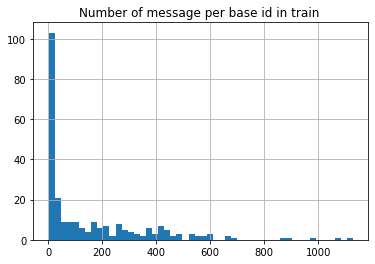

In [48]:
message_per_base_train['nb_message'].hist(bins = 50);
plt.title('Number of message per base id in train ')
plt.show()

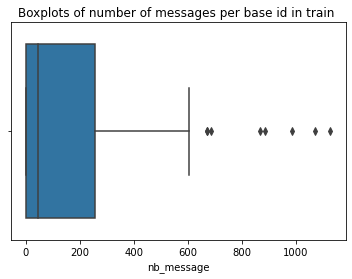

In [49]:
sns.boxplot(data = message_per_base_train, x = 'nb_message');
plt.title('Boxplots of number of messages per base id in train ')
plt.show()

In [50]:
message_per_base_test= df_mess_test.groupby(by= 'bsid').count().reset_index()[['bsid','messid']]
message_per_base_test.columns = ['bsid', 'nb_message']
message_per_base_test = message_per_base_test.sort_values(by = 'nb_message', ascending = False)
message_per_base_test

,bsid,nb_message
53,3025,1066
104,4058,817
24,1859,809
75,3547,772
34,2617,709
...,...,...
98,3835,1
162,8747,1
71,3535,1
142,8392,1


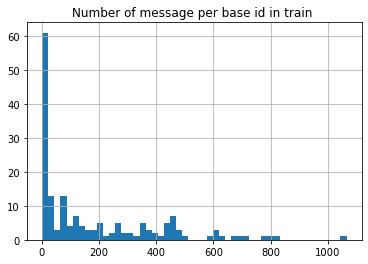

In [51]:
message_per_base_test['nb_message'].hist(bins = 50);
plt.title('Number of message per base id in train ')
plt.show()

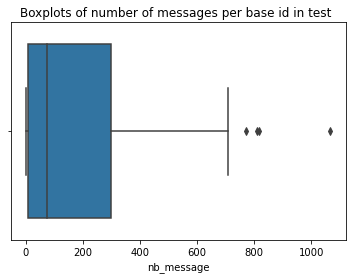

In [52]:
sns.boxplot(data = message_per_base_test, x = 'nb_message');
plt.title('Boxplots of number of messages per base id in test ')
plt.show()

The number of messages received per base is heavily desequilibrated. Many of them only receive a few messages. Maybe some of these bases could be removed when trainning the models.

### How many bases receive one message?

In [53]:
bases_per_message = pd.pivot_table(data =df_mess_train, 
              index = 'messid', 
              values = 'bsid', 
              aggfunc='nunique')
bases_per_message = bases_per_message[['bsid']]
bases_per_message = bases_per_message.reset_index()
bases_per_message = bases_per_message.sort_values(by = 'bsid', ascending = False)
bases_per_message.columns = ['messid', 'nb_bsid']
bases_per_message

,messid,nb_bsid
2261,57aeb41fe541cd77a044cdb8,106
5632,583c50decf554f7e3a360e58,81
5218,582c996c12f1434b9c20a854,80
5217,582c96ffcf554f7e3ab32732,80
5215,582c922212f1434b9c1aec97,77
...,...,...
3474,57ebffbe12f14320ffa20fe1,1
2142,57aa4ae212f14345917bba46,1
3473,57ebfd33cf554f31289c3a19,1
2148,57aabacce541cd77a09c0be4,1


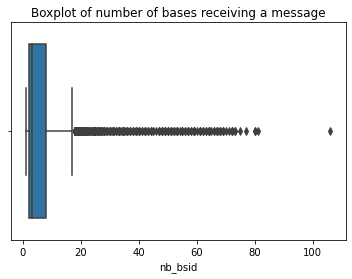

In [54]:
sns.boxplot(data = bases_per_message, x= 'nb_bsid');
plt.title("Boxplot of number of bases receiving a message")
plt.show()

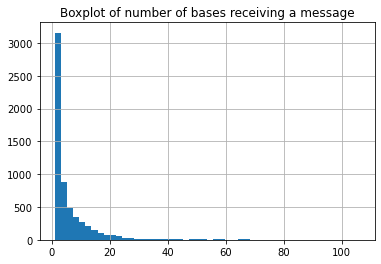

In [55]:
bases_per_message['nb_bsid'].hist(bins = 50);
plt.title("Boxplot of number of bases receiving a message")
plt.show()

In [56]:
bases_per_message.describe()

,nb_bsid
count,6068.000000
mean,6.468359
std,8.997655
min,1.000000
25%,2.000000
50%,3.000000
75%,8.000000
max,106.000000


- A message is received in average by 6 bases. 
- Only a few messages are received by a high number of bsid. 
- Only 25% are received by more than 8 bsid, and 25% are received only by 2 or less bases. 

### How many messages are sent by a unique device?

In [57]:
messsid_by_device =pd.pivot_table(data = df_train, 
              index = 'did', 
              values = 'messid', 
              aggfunc =  'nunique') [['messid']]
messsid_by_device = messsid_by_device.reset_index()
messsid_by_device = messsid_by_device.sort_values(by = 'messid', ascending = False)
messsid_by_device.columns  = ['did', 'nb_messid']
messsid_by_device

,did,nb_messid
27,476185.0,918
61,476327.0,681
73,476521.0,515
107,476889.0,369
69,476512.0,313
...,...,...
70,476513.0,1
37,476253.0,1
35,476248.0,1
32,476225.0,1


In [58]:
messsid_by_device.describe()

,nb_messid
count,113.000000
mean,53.699115
std,129.499923
min,1.000000
25%,4.000000
50%,10.000000
75%,43.000000
max,918.000000


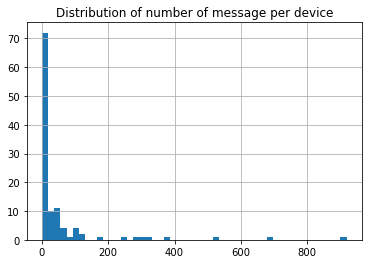

In [59]:
messsid_by_device['nb_messid'].hist(bins = 50);
plt.title("Distribution of number of message per device")
plt.show()

Some devices send a lot of messages, but the mean is around  53 messages, and a lot of the devices send only 1 message.

### Do the devices move a lot?

In [60]:
position_by_device = df_train.groupby(by= 'did').aggregate(['mean', 'min', 'max','count'])[['lat', 'lng']]
position_by_device = position_by_device.reset_index()
position_by_device

did        lat                                     lng              \
                     mean        min        max count        mean         min   
0    1747434.0  39.791255  39.771350  39.806762   119 -105.049394 -105.060649   
1    1747448.0  39.788769  39.771254  39.806297   120 -105.050743 -105.062672   
2     473288.0  39.774579  39.774541  39.775428   343 -105.039348 -105.039537   
3     473335.0  39.709192  39.597552  39.823482   459 -104.993414 -105.059794   
4     473368.0  39.755458  39.752367  39.768008    24 -105.007723 -105.015508   
..         ...        ...        ...        ...   ...         ...         ...   
108   476891.0  39.822241  39.818604  39.825306    22 -105.217972 -105.222775   
109   476896.0  40.271621  39.824026  41.279237    18 -105.510893 -106.115996   
110   476987.0  39.789259  39.742850  39.994692   311 -105.053012 -105.184677   
111   477023.0  39.828106  39.807619  39.835511    20 -105.182060 -105.218251   
112   477201.0  39.864938  39.819537  39.876481    74 -105.253230 -105.262660   

                       
            max count  
0   -105.041288   119  
1   -105.041462   120  
2   -105.039339   343  
3   -104.904989   459  
4   -105.004383    24  
..          ...   ...  
108 -105.216127    22  
109 -105.217132    18  
110 -104.996727   311  
111 -105.117610    20  
112 -105.216140    74  

[113 rows x 9 columns]

In [61]:
position_by_device.columns = ['_'.join(col) for col in position_by_device.columns]
position_by_device

,did_,lat_mean,lat_min,lat_max,lat_count,lng_mean,lng_min,lng_max,lng_count
0,1747434.0,39.791255,39.771350,39.806762,119,-105.049394,-105.060649,-105.041288,119
1,1747448.0,39.788769,39.771254,39.806297,120,-105.050743,-105.062672,-105.041462,120
2,473288.0,39.774579,39.774541,39.775428,343,-105.039348,-105.039537,-105.039339,343
3,473335.0,39.709192,39.597552,39.823482,459,-104.993414,-105.059794,-104.904989,459
4,473368.0,39.755458,39.752367,39.768008,24,-105.007723,-105.015508,-105.004383,24
...,...,...,...,...,...,...,...,...,...
108,476891.0,39.822241,39.818604,39.825306,22,-105.217972,-105.222775,-105.216127,22
109,476896.0,40.271621,39.824026,41.279237,18,-105.510893,-106.115996,-105.217132,18
110,476987.0,39.789259,39.742850,39.994692,311,-105.053012,-105.184677,-104.996727,311
111,477023.0,39.828106,39.807619,39.835511,20,-105.182060,-105.218251,-105.117610,20


We can notice that for a message, the latitude, and longitude are approximatively the same for the same device.
So we can add the average, mean, and max latitude and longitude registered for the  device as additional features.

### Is the location of the message in the centroid of bases that received the message?

In [62]:
position_by_messid = df_train.groupby(by= 'messid').aggregate(['mean', 'min', 'max','count'])[['bs_lat','lat', 'bs_lng','lng']]
position_by_messid = position_by_messid.reset_index()
position_by_messid

messid     bs_lat                              \
                                     mean        min        max count   
0     573bf1d9864fce1a9af8c5c9  39.647522  39.617794  39.677251     2   
1     573bf3533e952e19126b256a  39.612745  39.612745  39.612745     1   
2     573c0cd0f0fe6e735a699b93  39.751055  39.723151  39.797969     3   
3     573c1272f0fe6e735a6cb8bd  39.616885  39.495225  39.704887     4   
4     573c8ea8864fce1a9a5fbf7a  39.778865  39.612745  39.973995    42   
...                        ...        ...        ...        ...   ...   
6063  5848551912f14360d786ede6  44.673207  39.757034  64.300000     5   
6064  58485a25e541cd0e1329b8d6  39.678859  39.612745  39.706436     5   
6065  58485bd412f14360d78bebdb  52.040198  39.759396  64.300000    10   
6066  5848672e12f14360d7942374  44.660721  39.704887  64.300000     5   
6067  58487473e541cd0e133cca72  39.913654  39.898872  39.928436     2   

            lat                                  bs_lng              \
           mean        min        max count        mean         min   
0     39.606690  39.606690  39.606690     2 -104.953819 -104.954917   
1     39.637741  39.637741  39.637741     1 -105.008827 -105.008827   
2     39.730417  39.730417  39.730417     3 -105.001109 -105.073460   
3     39.693102  39.693102  39.693102     4 -105.030503 -105.053109   
4     39.758167  39.758167  39.758167    42 -105.033121 -105.165355   
...         ...        ...        ...   ...         ...         ...   
6063  39.764915  39.764915  39.764915     5  -97.697876 -105.009416   
6064  39.658804  39.658804  39.658804     5 -105.024327 -105.099323   
6065  39.778872  39.778872  39.778872    10  -86.761117 -105.062479   
6066  39.773264  39.773264  39.773264     5  -97.709197 -105.025753   
6067  39.908186  39.908186  39.908186     2 -105.163275 -105.172719   

                               lng                                
             max count        mean         min         max count  
0    -104.952721     2 -104.958490 -104.958490 -104.958490     2  
1    -105.008827     1 -104.958554 -104.958554 -104.958554     1  
2    -104.956216     3 -104.968940 -104.968940 -104.968940     3  
3    -105.008827     4 -105.006995 -105.006995 -105.006995     4  
4    -104.891717    42 -105.051016 -105.051016 -105.051016    42  
...          ...   ...         ...         ...         ...   ...  
6063  -68.500000     5 -105.003985 -105.003985 -105.003985     5  
6064 -104.952721     5 -105.008299 -105.008299 -105.008299     5  
6065  -68.500000    10 -105.019285 -105.019285 -105.019285    10  
6066  -68.500000     5 -105.014052 -105.014052 -105.014052     5  
6067 -105.153832     2 -105.168297 -105.168297 -105.168297     2  

[6068 rows x 17 columns]

In [63]:
position_by_messid.columns = ['_'.join(col) for col in position_by_messid]
position_by_messid

,messid_,bs_lat_mean,bs_lat_min,bs_lat_max,bs_lat_count,lat_mean,lat_min,lat_max,lat_count,bs_lng_mean,bs_lng_min,bs_lng_max,bs_lng_count,lng_mean,lng_min,lng_max,lng_count
0,573bf1d9864fce1a9af8c5c9,39.647522,39.617794,39.677251,2,39.606690,39.606690,39.606690,2,-104.953819,-104.954917,-104.952721,2,-104.958490,-104.958490,-104.958490,2
1,573bf3533e952e19126b256a,39.612745,39.612745,39.612745,1,39.637741,39.637741,39.637741,1,-105.008827,-105.008827,-105.008827,1,-104.958554,-104.958554,-104.958554,1
2,573c0cd0f0fe6e735a699b93,39.751055,39.723151,39.797969,3,39.730417,39.730417,39.730417,3,-105.001109,-105.073460,-104.956216,3,-104.968940,-104.968940,-104.968940,3
3,573c1272f0fe6e735a6cb8bd,39.616885,39.495225,39.704887,4,39.693102,39.693102,39.693102,4,-105.030503,-105.053109,-105.008827,4,-105.006995,-105.006995,-105.006995,4
4,573c8ea8864fce1a9a5fbf7a,39.778865,39.612745,39.973995,42,39.758167,39.758167,39.758167,42,-105.033121,-105.165355,-104.891717,42,-105.051016,-105.051016,-105.051016,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,5848551912f14360d786ede6,44.673207,39.757034,64.300000,5,39.764915,39.764915,39.764915,5,-97.697876,-105.009416,-68.500000,5,-105.003985,-105.003985,-105.003985,5
6064,58485a25e541cd0e1329b8d6,39.678859,39.612745,39.706436,5,39.658804,39.658804,39.658804,5,-105.024327,-105.099323,-104.952721,5,-105.008299,-105.008299,-105.008299,5
6065,58485bd412f14360d78bebdb,52.040198,39.759396,64.300000,10,39.778872,39.778872,39.778872,10,-86.761117,-105.062479,-68.500000,10,-105.019285,-105.019285,-105.019285,10
6066,5848672e12f14360d7942374,44.660721,39.704887,64.300000,5,39.773264,39.773264,39.773264,5,-97.709197,-105.025753,-68.500000,5,-105.014052,-105.014052,-105.014052,5


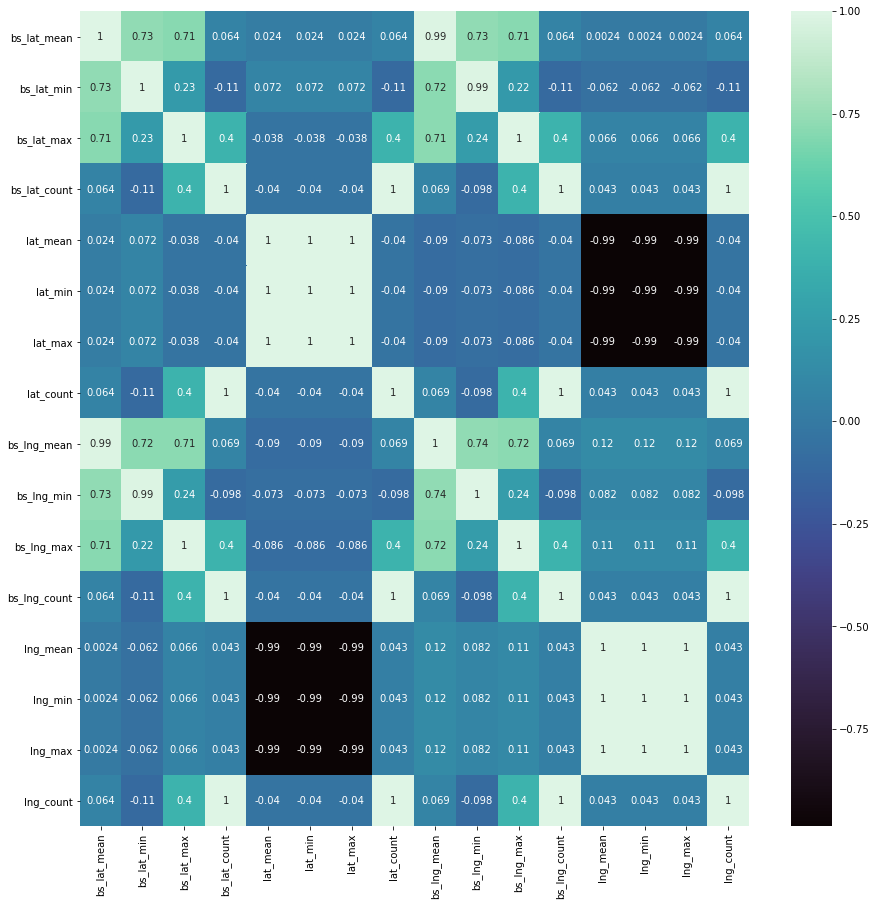

In [64]:
plt.figure(figsize = (15,15))
sns.heatmap(position_by_messid.corr(), cmap= 'mako', annot = True)
plt.show()

<Figure size 1440x1440 with 0 Axes>

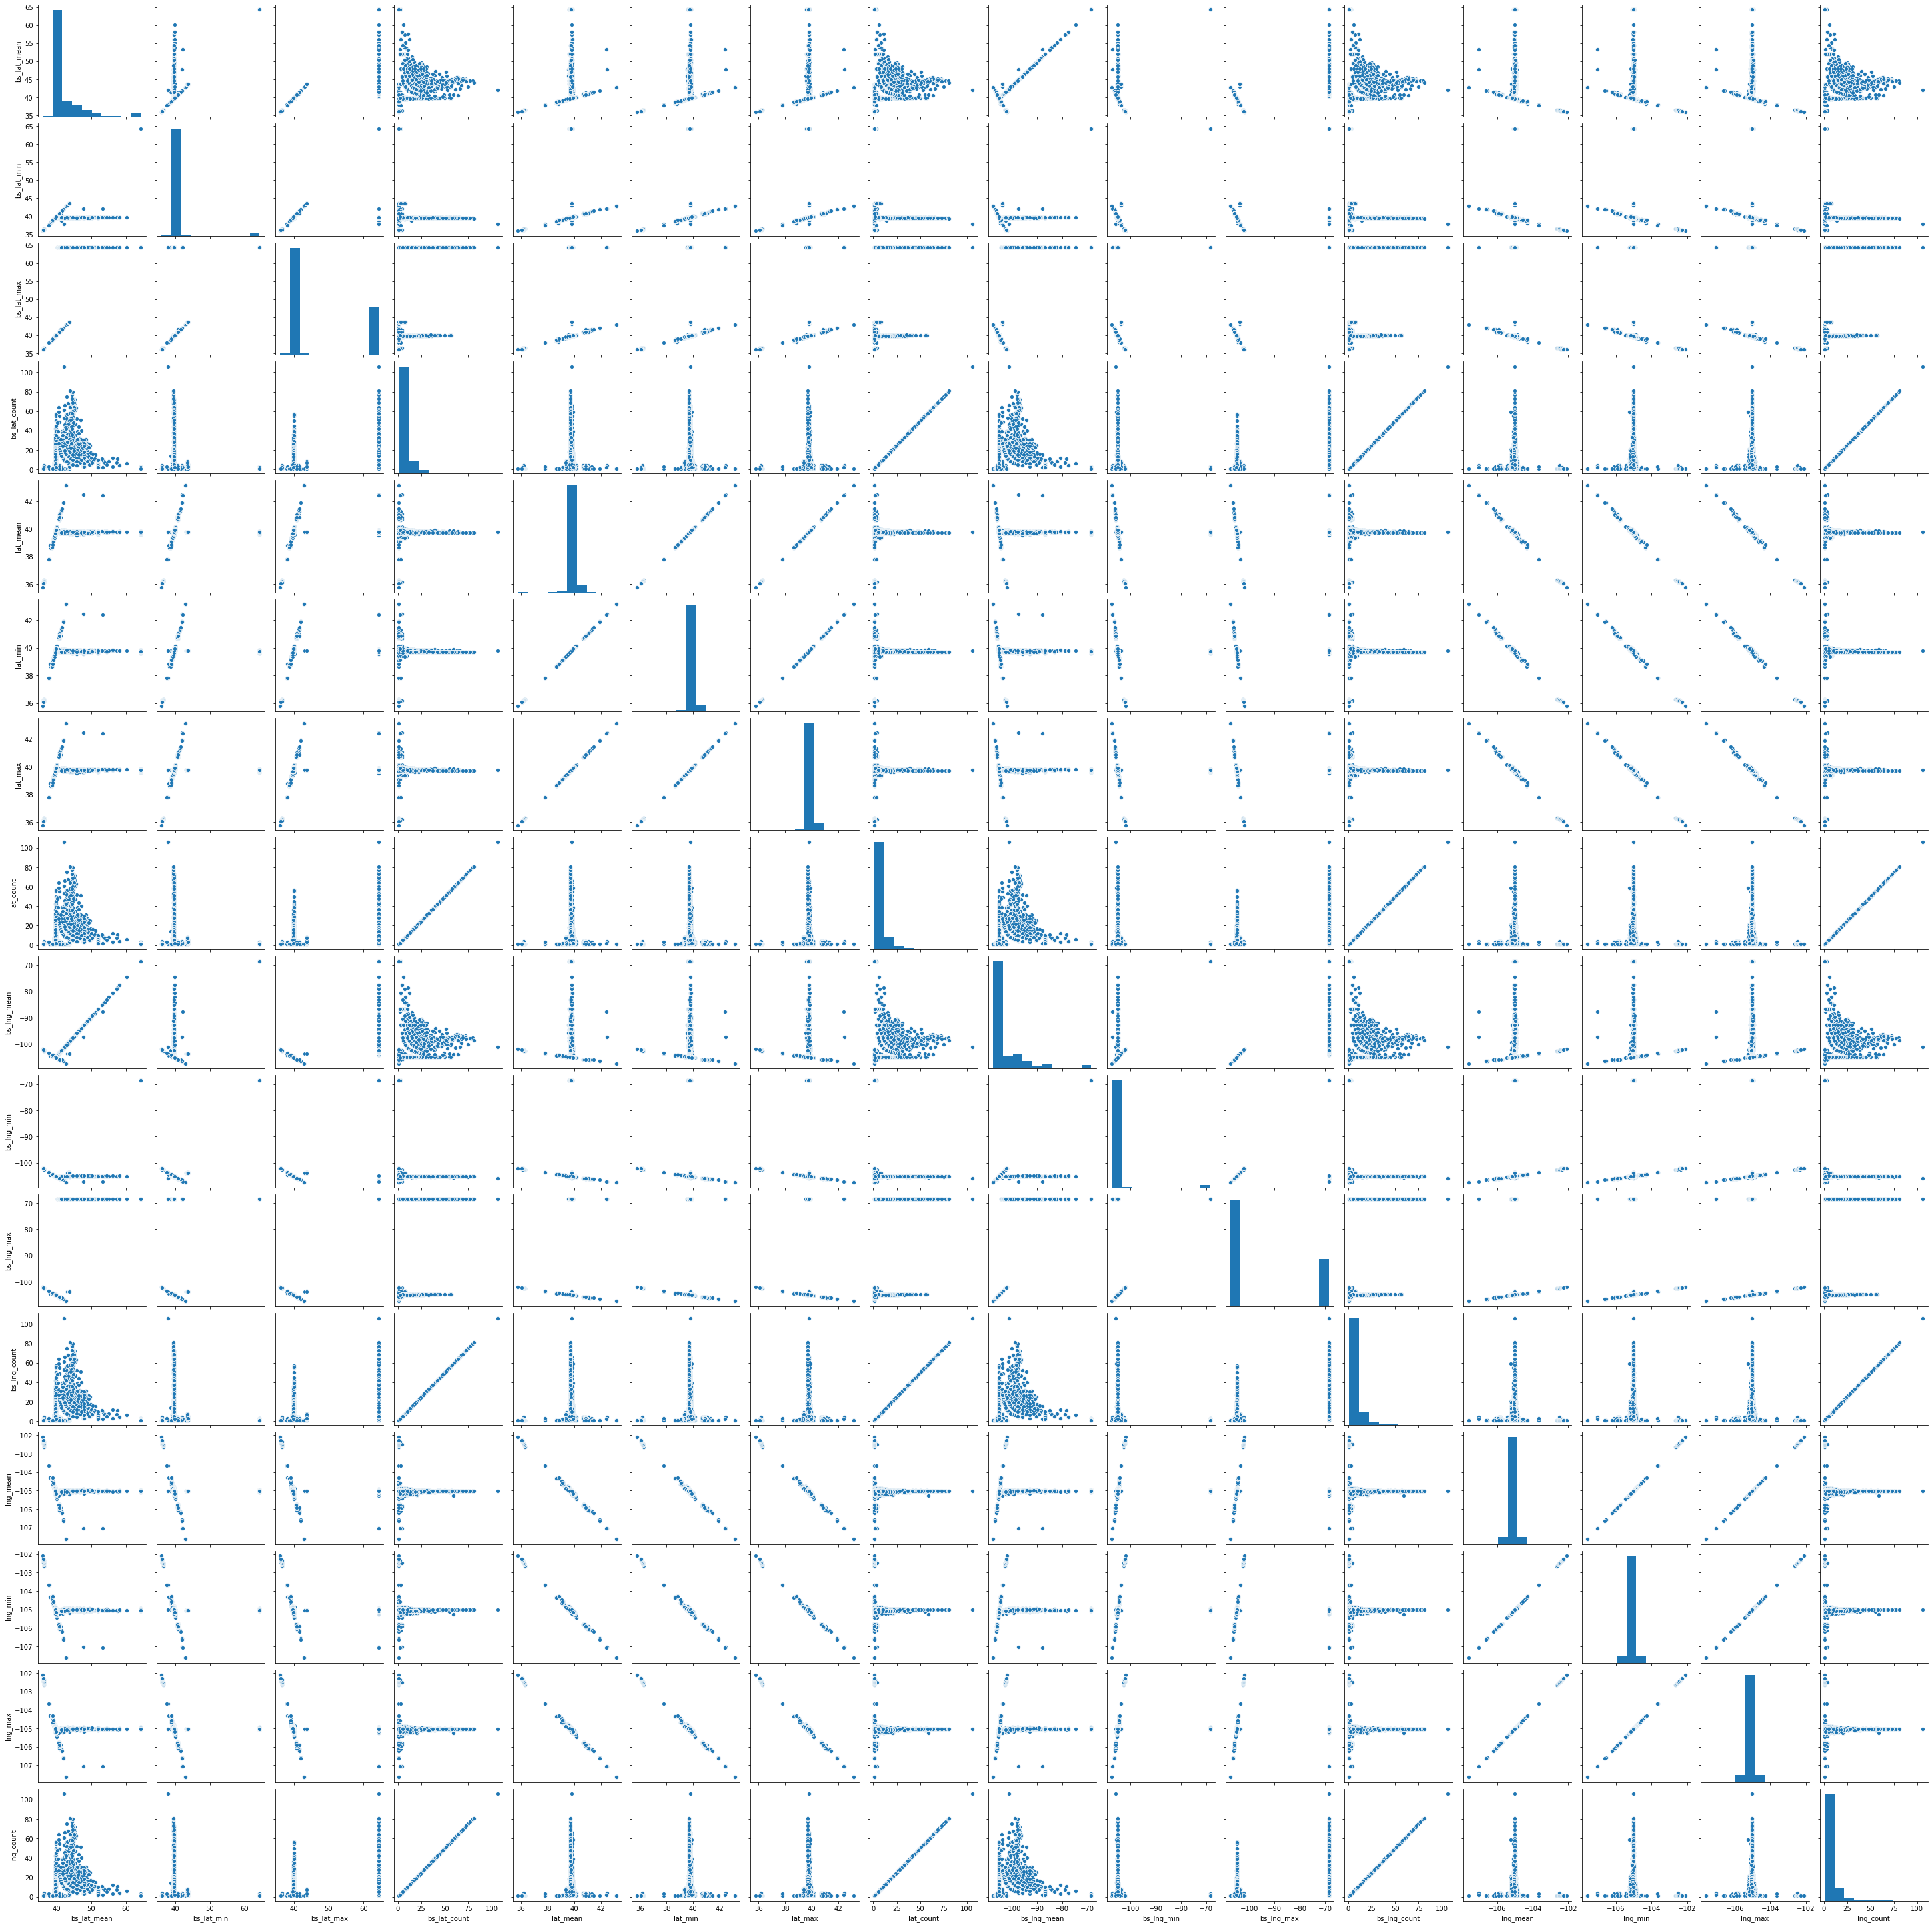

In [65]:
plt.figure(figsize = (20,20))
sns.pairplot(position_by_messid)
plt.show()

In [66]:
import re

In [67]:
cols = list(position_by_messid.columns)

In [68]:
latitude_columns = [s for s in cols if 'lat' in s]
longitude_columns = [s for s in cols if 'lng' in s]

<Figure size 1440x1440 with 0 Axes>

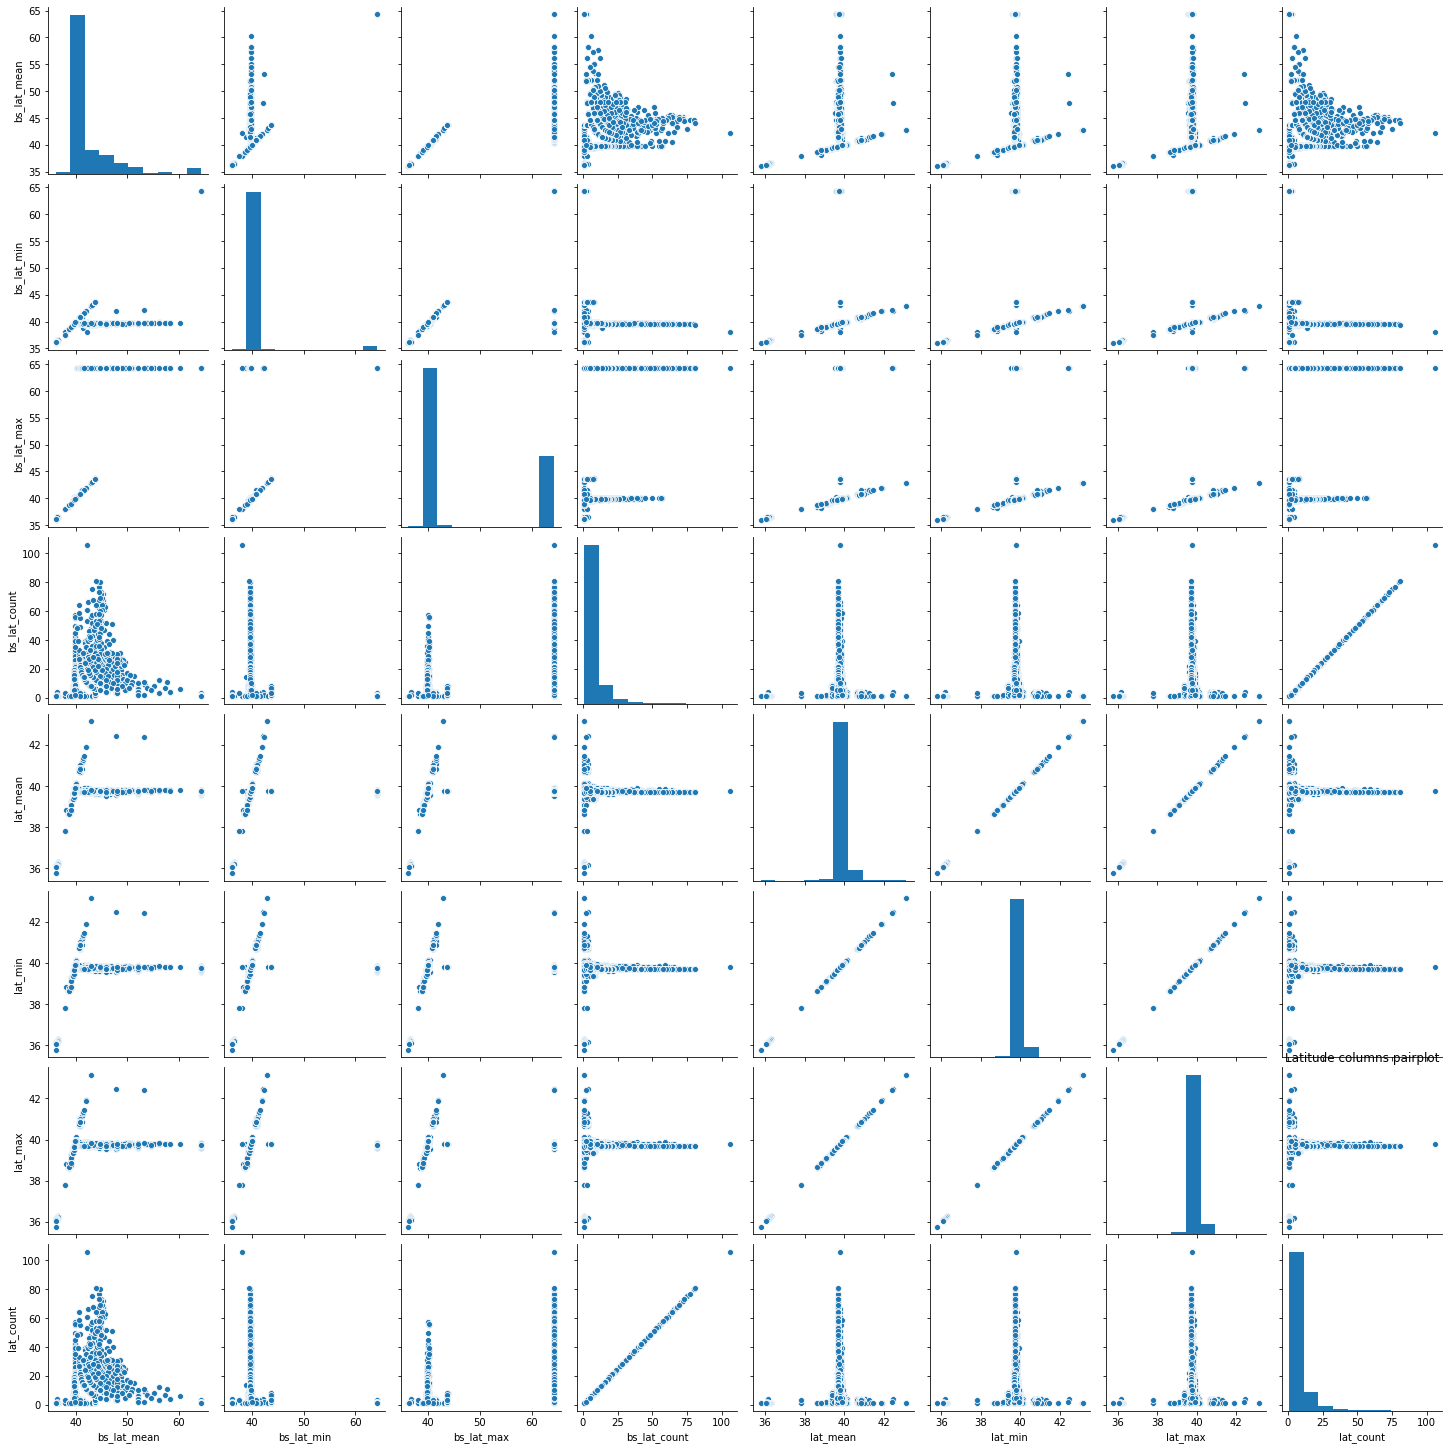

In [69]:
plt.figure(figsize = (20,20))
sns.pairplot(position_by_messid [latitude_columns]);
plt.title("Latitude columns pairplot")
plt.show()

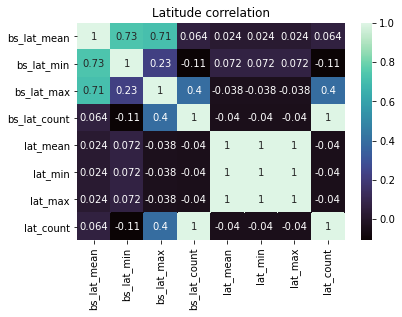

In [70]:
sns.heatmap(position_by_messid [latitude_columns].corr(), cmap = 'mako', 
           annot = True,)
plt.title("Latitude correlation")
plt.show()

<Figure size 1440x1440 with 0 Axes>

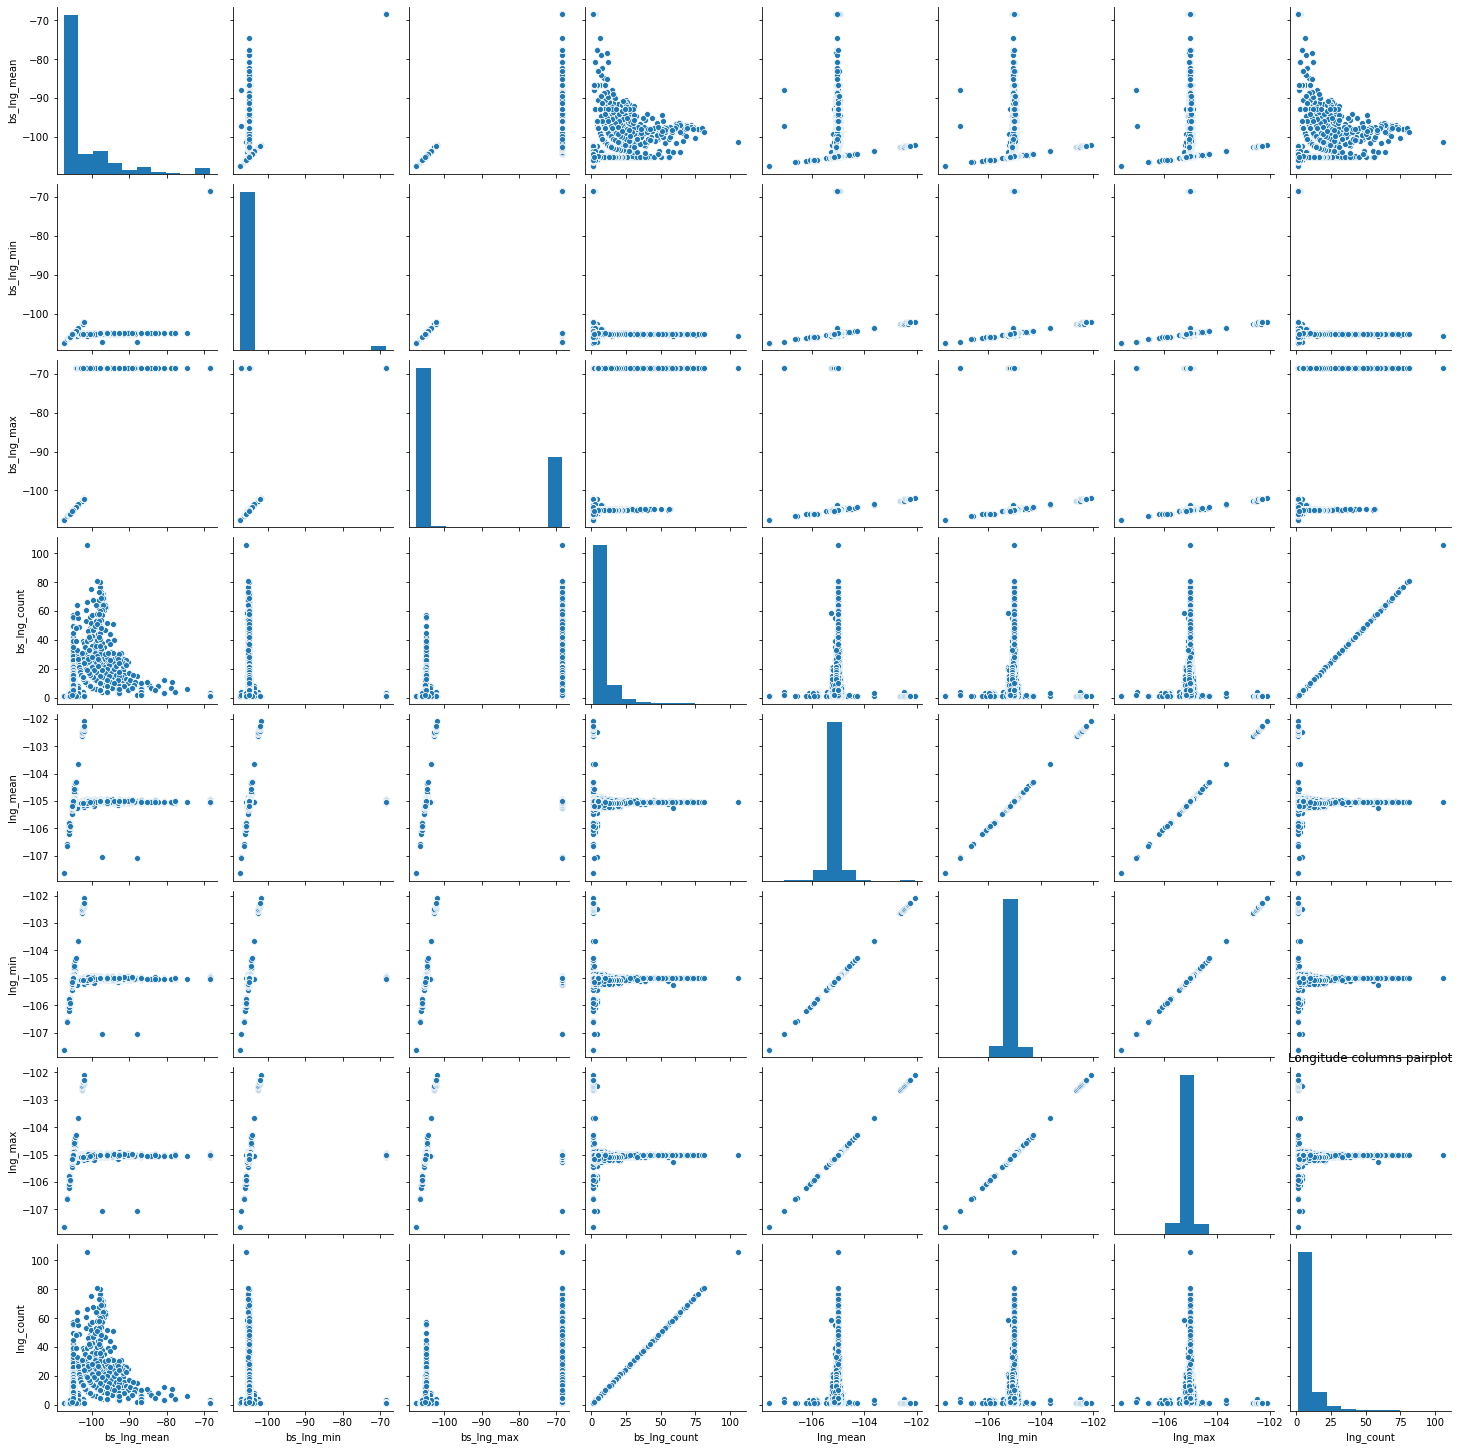

In [71]:
plt.figure(figsize = (20,20))
sns.pairplot(position_by_messid [longitude_columns]);
plt.title("Longitude columns pairplot")
plt.show()

We could notice a linear relationship with the features. So we could add these information. 

## Where are the messages located?

In [72]:
df_train

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,distance_message_base
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,1.270478
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,7.849924
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,5.131578
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,11.681759
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,1.356862
...,...,...,...,...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,3410,476257.0,1.0,-128.000000,1.481140e+12,39.777690,-105.002424,39.773264,-105.014052,1.110804
39246,5848672e12f14360d7942374,8352,476257.0,0.0,-121.000000,1.481140e+12,39.761633,-105.025753,39.773264,-105.014052,1.634839
39247,5848672e12f14360d7942374,8397,476257.0,2.0,-126.000000,1.481140e+12,39.759396,-105.001415,39.773264,-105.014052,1.882449
39248,58487473e541cd0e133cca72,3051,476593.0,1.0,-131.333333,1.481143e+12,39.898872,-105.153832,39.908186,-105.168297,1.612307


In [73]:
def Give_Marker_Cluster_lat_lng(df) :
    markers = []
    for i in df.index :
        x = df.loc[i].lat
        y = df.loc[i].lng
        name = str(df.loc[i].messid)
        markers.append(Marker(location = (x,y),draggable = False, title = name))

    return MarkerCluster(markers=(markers))

In [74]:
df_Coord = df_train.drop_duplicates(subset ="messid", 
                                       keep = 'first')[['messid','lat','lng']]

m = Map(center=(46, -1), zoom=2,
        basemap = basemaps.Stamen.Watercolor)

markerC = Give_Marker_Cluster_lat_lng(df_Coord)

m.add_layer(markerC)
display(m)

Map(center=[46, -1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

All the messages are located in the USA. So maybe removing the bsid in Canada could be interesting for the analysis. 

### Is the location for one message id unique?

In [75]:
df_train.groupby('messid').nunique()[['lat', 'lng']].sort_values(by = 'lat')

,lat,lng
messid,,
573bf1d9864fce1a9af8c5c9,1,1
5801fbace541cd17036b4198,1,1
5801fa3612f143344ce8d83c,1,1
5801f756cf554f7f6959b16c,1,1
5801f5f212f143344ce59260,1,1
...,...,...
57a55db1cf554f465afeb2e3,1,1
57a55c3212f14345916347ce,1,1
57a55aaa12f14345916274e9,1,1


In [76]:
df_train.groupby('messid').nunique()[['lat', 'lng']].sort_values(by = 'lng')

,lat,lng
messid,,
573bf1d9864fce1a9af8c5c9,1,1
5801fbace541cd17036b4198,1,1
5801fa3612f143344ce8d83c,1,1
5801f756cf554f7f6959b16c,1,1
5801f5f212f143344ce59260,1,1
...,...,...
57a55db1cf554f465afeb2e3,1,1
57a55c3212f14345916347ce,1,1
57a55aaa12f14345916274e9,1,1


A location for a message id is unique. 
Rather than analyzing the row for each signal it could be more interesting to aggregate information by messid. 

### Are there messages id in test that are in train ?

In [77]:
messages_train = list(df_train['messid'].unique())
messages_train 

['573bf1d9864fce1a9af8c5c9',
 '573bf3533e952e19126b256a',
 '573c0cd0f0fe6e735a699b93',
 '573c1272f0fe6e735a6cb8bd',
 '573c8ea8864fce1a9a5fbf7a',
 '573c9148864fce1a9a616174',
 '573c939cf0fe6e735ac36de1',
 '573c9667f0fe6e735ac51891',
 '573c9892f0fe6e735ac6603f',
 '573c9d7b3e952e1912d9f567',
 '573cbc43f0fe6e735adabf38',
 '573cbc7ff0fe6e735adadeab',
 '573cc276864fce1a9a7dd272',
 '573cc3e1864fce1a9a7e8cac',
 '573cc5753e952e1912f0d833',
 '573ce369f0fe6e735aeeebd8',
 '573ce5ca3e952e191201235f',
 '573d44aa3e952e19123052b2',
 '573d45c5f0fe6e735a1f0ae6',
 '573d5b6f864fce1a9acb9d38',
 '573d5da8864fce1a9acccdda',
 '573d681d864fce1a9ad29b41',
 '573d6abaf0fe6e735a332b84',
 '573d6d113e952e191246d944',
 '573d6f69f0fe6e735a367295',
 '573d71d6f0fe6e735a384aee',
 '573d744bf0fe6e735a3a2223',
 '573d76d6f0fe6e735a3be643',
 '573d791c3e952e1912500c1b',
 '573d9819f0fe6e735a5490e8',
 '573d9a84f0fe6e735a564e8d',
 '573da1c03e952e19126e2826',
 '573da452864fce1a9aff034f',
 '573da67a3e952e1912715bd7',
 '573da8cff0fe

In [78]:
messages_test = list(df_mess_test['messid'].unique())
messages_test

['573be2503e952e191262c351',
 '573c05f83e952e1912758013',
 '573c0796f0fe6e735a66deb3',
 '573c08d2864fce1a9a0563bc',
 '573c08ff864fce1a9a0579b0',
 '573c0a45f0fe6e735a684459',
 '573c0bb7f0fe6e735a6904a7',
 '573c161d3e952e19127e5da0',
 '573c201bf0fe6e735a759e7b',
 '573c2d133e952e19128e5fc9',
 '573c3147f0fe6e735a81c7c4',
 '573c32b7f0fe6e735a82cf57',
 '573c3445f0fe6e735a83e8a8',
 '573c35a3f0fe6e735a84f1b7',
 '573c3712864fce1a9a24a5cd',
 '573c5200864fce1a9a38329a',
 '573c5494864fce1a9a39fe2e',
 '573c555b864fce1a9a3a8653',
 '573c6593f0fe6e735aa64173',
 '573c6ab1f0fe6e735aa9801f',
 '573c7240864fce1a9a4d6026',
 '573c73b53e952e1912bf71bd',
 '573c75243e952e1912c05e9c',
 '573c9063864fce1a9a60d02e',
 '573c93cef0fe6e735ac38c13',
 '573c97153e952e1912d61e00',
 '573c983a3e952e1912d6c5ce',
 '573c98803e952e1912d6f352',
 '573c998e864fce1a9a666954',
 '573c9ae0f0fe6e735ac7b981',
 '573c9c55f0fe6e735ac8905a',
 '573c9cc43e952e1912d980f3',
 '573ca927864fce1a9a6fb49b',
 '573cccb2f0fe6e735ae38358',
 '573cd67b864f

In [79]:
for mess in messages_test: 
    if mess in messages_train:
        print(mess)

The base is well splitted

### Conclusions of analysis

##### Preprocessing
- bsid and did should be converted to string type

#####  Feature engineering
- we could add label of canadian or american to a bsid
- We could add a mean/min/max position of the device
- We could add the last position of the device 
- We coud add the center/mean/max/min of the bases location related to a message

#####  Other questions 
- Should we keep distances higher than 500
- should we consider the bases with same location as a unique one?
- Should we keep bases that receive only one message


# Data Preparation

### Import datasets

In [80]:
X_train = pd.read_csv('mess_train_list.csv')
X_test = pd.read_csv('mess_test_list.csv')
y_train = pd.read_csv('pos_train_list.csv')

In [81]:
X_train.shape

(39250, 8)

In [82]:
X_test.shape

(29286, 8)

### Convert to string stypes

In [83]:
X_train['bsid']  = X_train['bsid'].astype(int).astype(str)
X_train['did']  = X_train['did'].astype(int).astype(str)

X_test['bsid']  = X_test['bsid'].astype(int).astype(str)
X_test['did']  = X_test['did'].astype(int).astype(str)

### Create a general dataframe 

In [84]:
general_df = X_train.copy()
general_df ['lat'] = y_train['lat']
general_df ['lng'] = y_train ['lng']

In [85]:
general_df.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,473335,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


### Create bases label as canadian or american 

In [86]:
bases = X_train.append(X_test)
bases = bases.groupby('bsid')[['bs_lat', 'bs_lng']].mean()
bases = bases.reset_index()
bases['bs_country'] = bases['bs_lat'].apply(lambda x : x>64)*1
bases = bases[['bsid', 'bs_country']]
bases

,bsid,bs_country
0,1012,0
1,10134,0
2,10148,0
3,10151,1
4,10162,1
...,...,...
254,980,0
255,9899,0
256,9936,0
257,9941,1


### Create a device dataset 

In [87]:
devices = X_train.append(X_test)
devices = devices.groupby('did').agg(['mean', 'min', 'max'])[['bs_lat', 'bs_lng']]
devices.columns = ['_did_'.join(col) for col in devices.columns]
devices = devices.reset_index()
devices

,did,bs_lat_did_mean,bs_lat_did_min,bs_lat_did_max,bs_lng_did_mean,bs_lng_did_min,bs_lng_did_max
0,110335,39.770625,39.704887,39.807916,-105.084243,-105.165355,-105.016392
1,116331,40.410378,39.612745,64.300000,-104.320934,-105.344979,-68.500000
2,116333,39.777776,39.777776,39.777776,-104.963305,-104.963305,-104.963305
3,116339,42.225229,39.666188,64.300000,-101.440653,-105.344979,-68.500000
4,116374,41.641024,39.666188,64.300000,-102.392515,-105.239120,-68.500000
...,...,...,...,...,...,...,...
164,476891,39.804355,39.666188,39.898566,-105.144727,-105.239120,-104.941022
165,476896,40.268424,39.666188,41.564439,-105.452471,-106.247588,-105.016392
166,476987,45.569564,39.612745,64.300000,-96.489951,-105.344979,-68.500000
167,477023,39.874683,39.666188,40.048039,-105.166238,-105.309839,-105.077530


### Create a message_added features

In [88]:
messages_features = X_train.append(X_test)
messages_features = messages_features.groupby('messid').agg(['mean', 'min', 'max'])[['bs_lat', 'bs_lng', 'rssi']]
messages_features.columns = ['_mess_'.join(col) for col in messages_features.columns]
messages_features = messages_features.reset_index()
messages_features

,messid,bs_lat_mess_mean,bs_lat_mess_min,bs_lat_mess_max,bs_lng_mess_mean,bs_lng_mess_min,bs_lng_mess_max,rssi_mess_mean,rssi_mess_min,rssi_mess_max
0,573be2503e952e191262c351,39.728651,39.728651,39.728651,-105.163032,-105.163032,-105.163032,-111.000000,-111.0,-111.000000
1,573bf1d9864fce1a9af8c5c9,39.647522,39.617794,39.677251,-104.953819,-104.954917,-104.952721,-123.250000,-125.0,-121.500000
2,573bf3533e952e19126b256a,39.612745,39.612745,39.612745,-105.008827,-105.008827,-105.008827,-134.000000,-134.0,-134.000000
3,573c05f83e952e1912758013,39.763474,39.728651,39.783211,-105.094321,-105.165355,-105.053676,-126.125000,-136.0,-105.000000
4,573c0796f0fe6e735a66deb3,39.666322,39.612745,39.704887,-105.028319,-105.044371,-105.008827,-128.250000,-134.5,-119.500000
...,...,...,...,...,...,...,...,...,...,...
11357,58485bd412f14360d78bebdb,52.040198,39.759396,64.300000,-86.761117,-105.062479,-68.500000,-128.383333,-147.0,-112.333333
11358,58485da512f14360d78d5378,39.660435,39.654682,39.666188,-105.060608,-105.077530,-105.043685,-123.916667,-130.5,-117.333333
11359,5848672e12f14360d7942374,44.660721,39.704887,64.300000,-97.709197,-105.025753,-68.500000,-123.800000,-129.0,-115.000000
11360,58486d71e541cd0e1337e073,39.644538,39.612745,39.666188,-105.043347,-105.077530,-105.008827,-131.444444,-137.0,-124.666667


### Create the final data frames

In [89]:
# Create dataframe
X_train_f = X_train.groupby(by = ['messid','bsid', 'did'])[['nseq']].count()
X_train_f  =X_train_f.reset_index()

#join with bases
X_train_f  = pd.merge(X_train_f, bases, on = 'bsid', how = 'left')

# join with devices
X_train_f  = pd.merge(X_train_f, devices, on = 'did')

# join with messages features 
X_train_f  = pd.merge(X_train_f, messages_features, on = 'messid', how = 'left')

# final group information by messageid, mean
X_train_f = X_train_f.groupby('messid').mean()
X_train_f = X_train_f.reset_index()

# Drop nseq
X_train_f = X_train_f.drop('nseq', axis = 1)
X_train_f

,messid,bs_country,bs_lat_did_mean,bs_lat_did_min,bs_lat_did_max,bs_lng_did_mean,bs_lng_did_min,bs_lng_did_max,bs_lat_mess_mean,bs_lat_mess_min,bs_lat_mess_max,bs_lng_mess_mean,bs_lng_mess_min,bs_lng_mess_max,rssi_mess_mean,rssi_mess_min,rssi_mess_max
0,573bf1d9864fce1a9af8c5c9,0.0,41.232806,39.495225,64.300000,-102.789185,-105.239120,-68.500000,39.647522,39.617794,39.677251,-104.953819,-104.954917,-104.952721,-123.250000,-125.0,-121.500000
1,573bf3533e952e19126b256a,0.0,41.232806,39.495225,64.300000,-102.789185,-105.239120,-68.500000,39.612745,39.612745,39.612745,-105.008827,-105.008827,-105.008827,-134.000000,-134.0,-134.000000
2,573c0cd0f0fe6e735a699b93,0.0,41.238669,39.654682,64.300000,-102.777842,-105.165355,-68.500000,39.751055,39.723151,39.797969,-105.001109,-105.073460,-104.956216,-117.333333,-132.0,-100.000000
3,573c1272f0fe6e735a6cb8bd,0.0,42.332598,39.495225,64.300000,-101.106614,-105.211041,-68.500000,39.616885,39.495225,39.704887,-105.030503,-105.053109,-105.008827,-127.416667,-133.0,-123.333333
4,573c8ea8864fce1a9a5fbf7a,0.0,39.757280,39.612745,39.973995,-105.052947,-105.211041,-104.891717,39.778865,39.612745,39.973995,-105.033121,-105.165355,-104.891717,-125.996032,-141.0,-98.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,5848551912f14360d786ede6,0.2,42.609672,39.612745,64.300000,-100.843534,-105.239120,-68.500000,44.673207,39.757034,64.300000,-97.697876,-105.009416,-68.500000,-125.500000,-132.0,-117.000000
6064,58485a25e541cd0e1329b8d6,0.0,42.332598,39.495225,64.300000,-101.106614,-105.211041,-68.500000,39.678859,39.612745,39.706436,-105.024327,-105.099323,-104.952721,-129.566667,-137.0,-123.000000
6065,58485bd412f14360d78bebdb,0.5,42.609672,39.612745,64.300000,-100.843534,-105.239120,-68.500000,52.040198,39.759396,64.300000,-86.761117,-105.062479,-68.500000,-128.383333,-147.0,-112.333333
6066,5848672e12f14360d7942374,0.2,44.476772,39.417820,64.300000,-98.017004,-105.239120,-68.500000,44.660721,39.704887,64.300000,-97.709197,-105.025753,-68.500000,-123.800000,-129.0,-115.000000


In [90]:
# Create dataframe
X_test_f = X_test.groupby(by = ['messid','bsid', 'did'])[['nseq']].count()
X_test_f  =X_test_f.reset_index()

#join with bases
X_test_f  = pd.merge(X_test_f, bases, on = 'bsid', how = 'left')

# join with devices
X_test_f  = pd.merge(X_test_f, devices, on = 'did')

# join with messages features 
X_test_f  = pd.merge(X_test_f, messages_features, on = 'messid', how = 'left')

# final group information by messageid, mean
X_test_f = X_test_f.groupby('messid').mean()
X_test_f = X_test_f.reset_index()

# Drop nseq
X_test_f = X_test_f.drop('nseq', axis = 1)
X_test_f


,messid,bs_country,bs_lat_did_mean,bs_lat_did_min,bs_lat_did_max,bs_lng_did_mean,bs_lng_did_min,bs_lng_did_max,bs_lat_mess_mean,bs_lat_mess_min,bs_lat_mess_max,bs_lng_mess_mean,bs_lng_mess_min,bs_lng_mess_max,rssi_mess_mean,rssi_mess_min,rssi_mess_max
0,573be2503e952e191262c351,0.000000,39.941160,39.637669,64.3,-104.821647,-105.244856,-68.5,39.728651,39.728651,39.728651,-105.163032,-105.163032,-105.163032,-111.000000,-111.000000,-111.000000
1,573c05f83e952e1912758013,0.000000,42.941969,39.495225,64.3,-100.330156,-105.244856,-68.5,39.763474,39.728651,39.783211,-105.094321,-105.165355,-105.053676,-126.125000,-136.000000,-105.000000
2,573c0796f0fe6e735a66deb3,0.000000,40.038293,39.495225,64.3,-104.489054,-105.239120,-68.5,39.666322,39.612745,39.704887,-105.028319,-105.044371,-105.008827,-128.250000,-134.500000,-119.500000
3,573c08d2864fce1a9a0563bc,0.000000,42.941969,39.495225,64.3,-100.330156,-105.244856,-68.5,39.782113,39.782113,39.782113,-105.072701,-105.072701,-105.072701,-113.000000,-113.000000,-113.000000
4,573c08ff864fce1a9a0579b0,0.000000,40.038293,39.495225,64.3,-104.489054,-105.239120,-68.5,39.666322,39.612745,39.704887,-105.028319,-105.044371,-105.008827,-129.208333,-134.000000,-121.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,58484ca812f14360d7808eb0,0.250000,41.486886,39.612745,64.3,-102.469035,-105.239120,-68.5,45.885533,39.732045,64.300000,-95.847700,-104.976127,-68.500000,-128.916667,-133.000000,-125.000000
5290,58484cb6e541cd0e131f862c,0.285714,42.941969,39.495225,64.3,-100.330156,-105.244856,-68.5,46.784308,39.666188,64.300000,-94.587609,-105.077530,-68.500000,-126.857143,-138.000000,-114.500000
5291,58484dc9cf554f422f94665b,0.000000,40.038293,39.495225,64.3,-104.489054,-105.239120,-68.5,39.656647,39.612745,39.692976,-105.043603,-105.077530,-105.008827,-128.708333,-134.333333,-123.500000
5292,58485da512f14360d78d5378,0.000000,40.038293,39.495225,64.3,-104.489054,-105.239120,-68.5,39.660435,39.654682,39.666188,-105.060608,-105.077530,-105.043685,-123.916667,-130.500000,-117.333333


In [91]:
y_train_f = general_df.groupby('messid')[['lat', 'lng']].mean()
y_train_f = y_train_f.reset_index()
y_train_f = y_train_f.drop('messid', axis =1)
y_train_f

,lat,lng
0,39.606690,-104.958490
1,39.637741,-104.958554
2,39.730417,-104.968940
3,39.693102,-105.006995
4,39.758167,-105.051016
...,...,...
6063,39.764915,-105.003985
6064,39.658804,-105.008299
6065,39.778872,-105.019285
6066,39.773264,-105.014052


## Linear regression models  to predict longitude 

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [93]:
final_train_data = X_train_f.copy()
final_train_data[y_train_f.columns] = y_train_f

In [94]:
final_train_data.corr()['lng']

bs_country          0.075662
bs_lat_did_mean     0.131586
bs_lat_did_min     -0.272152
bs_lat_did_max      0.517479
bs_lng_did_mean     0.289879
bs_lng_did_min      0.313511
bs_lng_did_max      0.537148
bs_lat_mess_mean    0.002423
bs_lat_mess_min    -0.062057
bs_lat_mess_max     0.066423
bs_lng_mess_mean    0.115765
bs_lng_mess_min     0.082275
bs_lng_mess_max     0.114113
rssi_mess_mean     -0.145524
rssi_mess_min      -0.102051
rssi_mess_max      -0.099906
lat                -0.987511
lng                 1.000000
Name: lng, dtype: float64

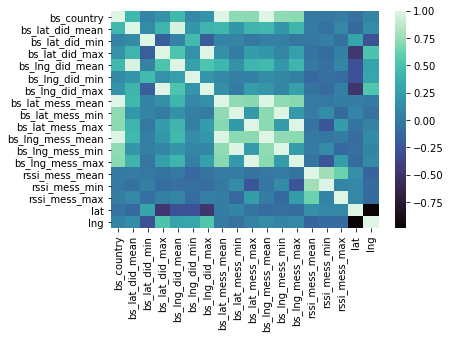

In [95]:
sns.heatmap(final_train_data.corr(), cmap = 'mako')

In [96]:
X_train_cv = X_train_f.drop('messid', axis = 1)
y_train_cv = np.array(y_train_f['lng'])

In [97]:
X_train_cv

,bs_country,bs_lat_did_mean,bs_lat_did_min,bs_lat_did_max,bs_lng_did_mean,bs_lng_did_min,bs_lng_did_max,bs_lat_mess_mean,bs_lat_mess_min,bs_lat_mess_max,bs_lng_mess_mean,bs_lng_mess_min,bs_lng_mess_max,rssi_mess_mean,rssi_mess_min,rssi_mess_max
0,0.0,41.232806,39.495225,64.300000,-102.789185,-105.239120,-68.500000,39.647522,39.617794,39.677251,-104.953819,-104.954917,-104.952721,-123.250000,-125.0,-121.500000
1,0.0,41.232806,39.495225,64.300000,-102.789185,-105.239120,-68.500000,39.612745,39.612745,39.612745,-105.008827,-105.008827,-105.008827,-134.000000,-134.0,-134.000000
2,0.0,41.238669,39.654682,64.300000,-102.777842,-105.165355,-68.500000,39.751055,39.723151,39.797969,-105.001109,-105.073460,-104.956216,-117.333333,-132.0,-100.000000
3,0.0,42.332598,39.495225,64.300000,-101.106614,-105.211041,-68.500000,39.616885,39.495225,39.704887,-105.030503,-105.053109,-105.008827,-127.416667,-133.0,-123.333333
4,0.0,39.757280,39.612745,39.973995,-105.052947,-105.211041,-104.891717,39.778865,39.612745,39.973995,-105.033121,-105.165355,-104.891717,-125.996032,-141.0,-98.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,0.2,42.609672,39.612745,64.300000,-100.843534,-105.239120,-68.500000,44.673207,39.757034,64.300000,-97.697876,-105.009416,-68.500000,-125.500000,-132.0,-117.000000
6064,0.0,42.332598,39.495225,64.300000,-101.106614,-105.211041,-68.500000,39.678859,39.612745,39.706436,-105.024327,-105.099323,-104.952721,-129.566667,-137.0,-123.000000
6065,0.5,42.609672,39.612745,64.300000,-100.843534,-105.239120,-68.500000,52.040198,39.759396,64.300000,-86.761117,-105.062479,-68.500000,-128.383333,-147.0,-112.333333
6066,0.2,44.476772,39.417820,64.300000,-98.017004,-105.239120,-68.500000,44.660721,39.704887,64.300000,-97.709197,-105.025753,-68.500000,-123.800000,-129.0,-115.000000


In [98]:


# Initialiez the scaler and fit to data
scaler = StandardScaler()
scaler.fit(X_train_cv)
X_train_cv = np.array(scaler.transform(X_train_cv))


In [99]:
def find_p(dico, value):
    """
    Return first key in dictionnary, 
    to wich the value in dictionnary matches the value in argument
    """
    for k,v in dico.items():
        if v== value:
            return k
        print("errror")
    pass

#### Lasso

In [100]:
alphas = np.linspace(0.002,0.1,100)


In [101]:

dico_alpha_MSE= {}
cv = KFold(n_splits = 5, shuffle=True, random_state= 42)
# For all alpha
for alpha in alphas:
    mse_fold = 0
    model = Lasso(alpha = alpha, max_iter=100000) #, normalize= True)
  
    # For all folds
    for train_index, test_index in cv.split(X_train_cv):
        # set train and test set 
        X_train_fold, X_test_fold = X_train_cv[train_index], X_train_cv[test_index]
        y_train_fold, y_test_fold = y_train_cv[train_index], y_train_cv[test_index]

        #Fit the model
        model.fit(X_train_fold, y_train_fold)

        # prediction on X_test_fold
        y_pred_fold = model.predict(X_test_fold)
        # add mse
        mse_fold = mse_fold + MSE(y_test_fold, y_pred_fold)

        # Get mean of mse on folds
        mse_fold = mse_fold/4
        
        # Add to dictionnary
        dico_alpha_MSE[alpha] = mse_fold


In [102]:
alpha_lasso = find_p(dico_alpha_MSE, min(dico_alpha_MSE.values()))
alpha_lasso

0.002

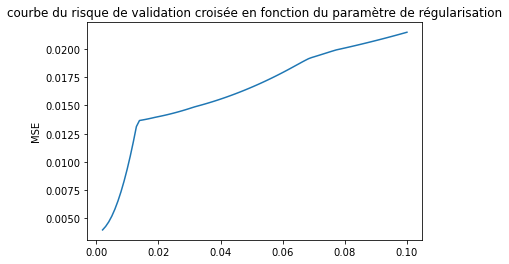

In [103]:
plt.plot(list(dico_alpha_MSE.keys()), list(dico_alpha_MSE.values()))
plt.title("courbe du risque de validation croisée en fonction du paramètre de régularisation")
plt.ylabel("alpha")
plt.ylabel("MSE")
plt.show()

In [104]:
lasso_cv =  LassoCV(alphas= alphas, cv = cv,
                    max_iter = 50000, 
                    fit_intercept = True)
lasso_cv .fit(X_train_cv, y_train_cv)

LassoCV(alphas=array([0.002     , 0.0029899 , 0.0039798 , 0.0049697 , 0.0059596 ,
       0.00694949, 0.00793939, 0.00892929, 0.00991919, 0.01090909,
       0.01189899, 0.01288889, 0.01387879, 0.01486869, 0.01585859,
       0.01684848, 0.01783838, 0.01882828, 0.01981818, 0.02080808,
       0.02179798, 0.02278788, 0.02377778, 0.02476768, 0.02575758,
       0.02674747, 0.02773737, 0.02872727, 0.02971717, 0.03070707,
       0.03169...
       0.07129293, 0.07228283, 0.07327273, 0.07426263, 0.07525253,
       0.07624242, 0.07723232, 0.07822222, 0.07921212, 0.08020202,
       0.08119192, 0.08218182, 0.08317172, 0.08416162, 0.08515152,
       0.08614141, 0.08713131, 0.08812121, 0.08911111, 0.09010101,
       0.09109091, 0.09208081, 0.09307071, 0.09406061, 0.09505051,
       0.0960404 , 0.0970303 , 0.0980202 , 0.0990101 , 0.1       ]),
        cv=KFold(n_splits=5, random_state=42, shuffle=True), max_iter=50000)

In [105]:
print("The optimal parameter is :", round(lasso_cv.alpha_,4))

The optimal parameter is : 0.002


In [106]:
lasso_cv.coef_

array([-0.0094829 ,  0.        , -0.0387514 ,  0.        ,  0.00558266,
        0.05157032,  0.05256327, -0.        , -1.14266496, -0.        ,
        0.        ,  1.14582371,  0.        , -0.00655114,  0.        ,
       -0.01580365])

#### Final lasso 

In [107]:
final_lasso = Lasso(alpha = lasso_cv.alpha_, max_iter = 50000)
final_lasso.fit(X_train_cv, y_train_cv)

Lasso(alpha=0.002, max_iter=50000)

In [108]:
y_pred = final_lasso.predict(X_train_cv)
MSE(y_pred, y_train_cv)

0.013812320606354917

#### Ridge

In [109]:

dico_alpha_MSE= {}
cv = KFold(n_splits = 5, shuffle=True, random_state= 42)
# For all alpha
for alpha in alphas:
    mse_fold = 0
    model = Ridge(alpha = alpha) #, normalize= True)
  
    # For all folds
    for train_index, test_index in cv.split(X_train_cv):
        # set train and test set 
        X_train_fold, X_test_fold = X_train_cv[train_index], X_train_cv[test_index]
        y_train_fold, y_test_fold = y_train_cv[train_index], y_train_cv[test_index]

        #Fit the model
        model.fit(X_train_fold, y_train_fold)

        # prediction on X_test_fold
        y_pred_fold = model.predict(X_test_fold)
        # add mse
        mse_fold = mse_fold + MSE(y_test_fold, y_pred_fold)

        # Get mean of mse on folds
        mse_fold = mse_fold/4
        
        # Add to dictionnary
        dico_alpha_MSE[alpha] = mse_fold


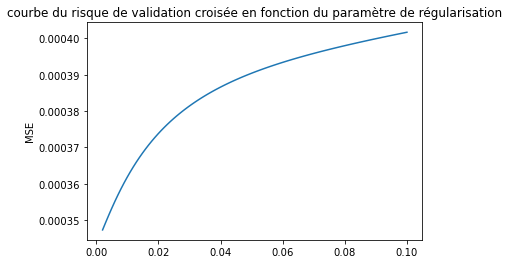

In [110]:
plt.plot(list(dico_alpha_MSE.keys()), list(dico_alpha_MSE.values()))
plt.title("courbe du risque de validation croisée en fonction du paramètre de régularisation")
plt.ylabel("alpha")
plt.ylabel("MSE")
plt.show()

In [111]:
alpha_ridge = find_p(dico_alpha_MSE, min(dico_alpha_MSE.values()))
alpha_ridge

0.002

In [112]:
ridge_cv =  RidgeCV(alphas= alphas, cv = cv, fit_intercept = True, scoring= 'neg_mean_squared_error' )
ridge_cv.fit(X_train_cv, y_train_cv)

RidgeCV(alphas=array([0.002     , 0.0029899 , 0.0039798 , 0.0049697 , 0.0059596 ,
       0.00694949, 0.00793939, 0.00892929, 0.00991919, 0.01090909,
       0.01189899, 0.01288889, 0.01387879, 0.01486869, 0.01585859,
       0.01684848, 0.01783838, 0.01882828, 0.01981818, 0.02080808,
       0.02179798, 0.02278788, 0.02377778, 0.02476768, 0.02575758,
       0.02674747, 0.02773737, 0.02872727, 0.02971717, 0.03070707,
       0.03169...
       0.07129293, 0.07228283, 0.07327273, 0.07426263, 0.07525253,
       0.07624242, 0.07723232, 0.07822222, 0.07921212, 0.08020202,
       0.08119192, 0.08218182, 0.08317172, 0.08416162, 0.08515152,
       0.08614141, 0.08713131, 0.08812121, 0.08911111, 0.09010101,
       0.09109091, 0.09208081, 0.09307071, 0.09406061, 0.09505051,
       0.0960404 , 0.0970303 , 0.0980202 , 0.0990101 , 0.1       ]),
        cv=KFold(n_splits=5, random_state=42, shuffle=True),
        scoring='neg_mean_squared_error')

In [113]:
print("The optimal parameter is", round(ridge_cv.alpha_,4))

The optimal parameter is 0.002


In [114]:
ridge_cv.best_score_

-0.0011361775259114016

In [115]:
ridge_cv.coef_

array([-3.85391457e+00, -1.39171060e-02, -2.49384688e-03,  1.53630768e-01,
        1.41009624e-02,  6.72305974e-03, -1.52702976e-01, -1.71888873e+00,
       -2.55589958e-01,  2.21624432e+00,  5.59013347e+00,  2.57029926e-01,
       -2.22095258e+00, -3.65884167e-03,  3.37456035e-03, -1.96687872e-03])

In [116]:
final_ridge = Ridge(alpha = ridge_cv.alpha_, max_iter = 50000,)
final_ridge.fit(X_train_cv, y_train_cv)

Ridge(alpha=0.002, max_iter=50000)

In [117]:
y_pred = final_ridge.predict(X_train_cv)
MSE(y_pred, y_train_cv)

0.0009792040033853805

In [118]:
final_ridge.coef_

array([-3.85391457e+00, -1.39171060e-02, -2.49384688e-03,  1.53630768e-01,
        1.41009624e-02,  6.72305974e-03, -1.52702976e-01, -1.71888873e+00,
       -2.55589958e-01,  2.21624432e+00,  5.59013347e+00,  2.57029926e-01,
       -2.22095258e+00, -3.65884167e-03,  3.37456035e-03, -1.96687872e-03])

# KNN Regressor

In [119]:
from sklearn.neighbors import KNeighborsRegressor

In [120]:
X_train_knn , X_val_knn = train_test_split(X_train_cv,test_size=0.2,  random_state = 42)
y_train_knn , y_val_knn = train_test_split(y_train_cv, test_size=0.2,random_state = 42)

In [121]:
list_error_train = []
list_error_val = []
list_k = list(range(1,30))


for k in list_k   :
    clf = KNeighborsRegressor(n_neighbors=k)
    clf.fit(X_train_knn, y_train_knn)
    
    # Compute error on train
    err_train =  MSE(clf.predict(X_train_knn), y_train_knn)
    list_error_train.append(err_train)
    
    # Compute error on train
    err_val =  MSE(clf.predict(X_val_knn), y_val_knn)
    list_error_val .append(err_val)
    

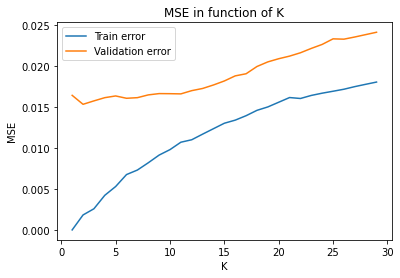

In [122]:
plt.plot(list_k, list_error_train, label = 'Train error')
plt.plot(list_k, list_error_val, label = 'Validation error')

plt.title("MSE in function of K")
plt.xlabel("K")
plt.ylabel("MSE")
plt.legend()
plt.show()

The model does not seem to perform really well for this proble in comparison with the linear models/ linear regression, lasso and ridge. 

# Ensemble methods

### Random Forest Regressor 

In [123]:
from sklearn.ensemble import RandomForestRegressor

In [124]:
from sklearn.model_selection import GridSearchCV

In [125]:
model = RandomForestRegressor()

In [126]:
grid = {}
grid['max_depth'] = [100* k for k in range(1,10)]
grid['n_estimators']= [100* k for k in range(1,10)]

In [127]:
grid_search = GridSearchCV(model, param_grid=grid, cv = 10)

In [ ]:
grid_search.fit(X_train_cv, y_train_cv)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
rf = grid_search.best_estimator